In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, norm

import IPython

sns.set(color_codes=True)

num_seeds = 41
test_idx = 6558
style = "top_infl"#"random"
top_cutoff = 50#100
group_sz = 36

predicted_loss_diffs = [None] * num_seeds
predicted_loss_diffs_ordered = [None] * num_seeds
predicted_loss_diffs_abs_indices = [None] * num_seeds
means = [None] * num_seeds
stddevs = [None] * num_seeds
mins = [None] * num_seeds
q1s = [None] * num_seeds
meds = [None] * num_seeds
q3s = [None] * num_seeds
maxs = [None] * num_seeds
influential_indices = np.array([],dtype=np.int32)

def ceil_divide(numer,denom):
    return (numer-1)//denom+1

In [2]:
for seed in range(num_seeds):
    f = np.load('../../scr/output/mnist_small_all_cnn_c_hidden2_seed{}_wd1_damping2_iter-300000_predicted_loss_diffs-test-{}.npz'.format(seed, [test_idx]))
    predicted_loss_diffs[seed] = f['predicted_loss_diffs']
    num_points = len(predicted_loss_diffs[seed])
    predicted_loss_diffs_ordered[seed] = np.sort(predicted_loss_diffs[seed])
    predicted_loss_diffs_abs_indices[seed] = np.argsort(np.abs(predicted_loss_diffs[seed]))
    influential_indices = np.union1d(influential_indices, predicted_loss_diffs_abs_indices[seed][-top_cutoff:])
    means[seed], stddevs[seed] = norm.fit(predicted_loss_diffs_ordered[seed])
    mins[seed] = predicted_loss_diffs_ordered[seed][0]
    q1s[seed] = predicted_loss_diffs_ordered[seed][num_points//4]
    meds[seed] = predicted_loss_diffs_ordered[seed][num_points//2]
    q3s[seed] = predicted_loss_diffs_ordered[seed][num_points//4+num_points//2]
    maxs[seed] = predicted_loss_diffs_ordered[seed][-1]

predicted_loss_diffs = np.array(predicted_loss_diffs)
predicted_loss_diffs_ordered = np.array(predicted_loss_diffs_ordered)
predicted_loss_diffs_abs_indices = np.array(predicted_loss_diffs_abs_indices)
means = np.array(means)
stddevs = np.array(stddevs)
mins = np.array(mins)
q1s = np.array(q1s)
meds = np.array(meds)
q3s = np.array(q3s)
maxs = np.array(maxs)

np.savez('../../scr/output/mnist_small_all_cnn_c_hidden2_41seeds_top_indices.npz',
        influential_indices=influential_indices)
# normalize
# new mean/stddevs with normalized
# extract influential points (top n, far enough on gaussian)
# check test_idx prediction

Text(0.5,1,u'Standard deviations over seeds')

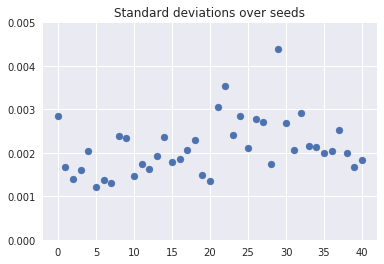

In [3]:
plt.ylim(0, 0.005)
plt.scatter(range(num_seeds), stddevs)
plt.title('Standard deviations over seeds')

Text(0.5,1,u'Means over seeds')

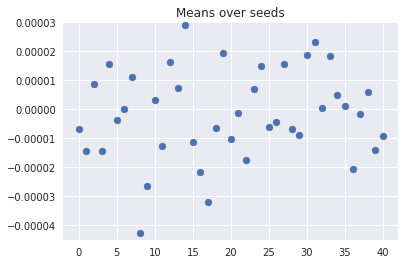

In [9]:
plt.ylim(-0.000045, 0.00003)
plt.scatter(range(num_seeds), means)
plt.title('Means over seeds')

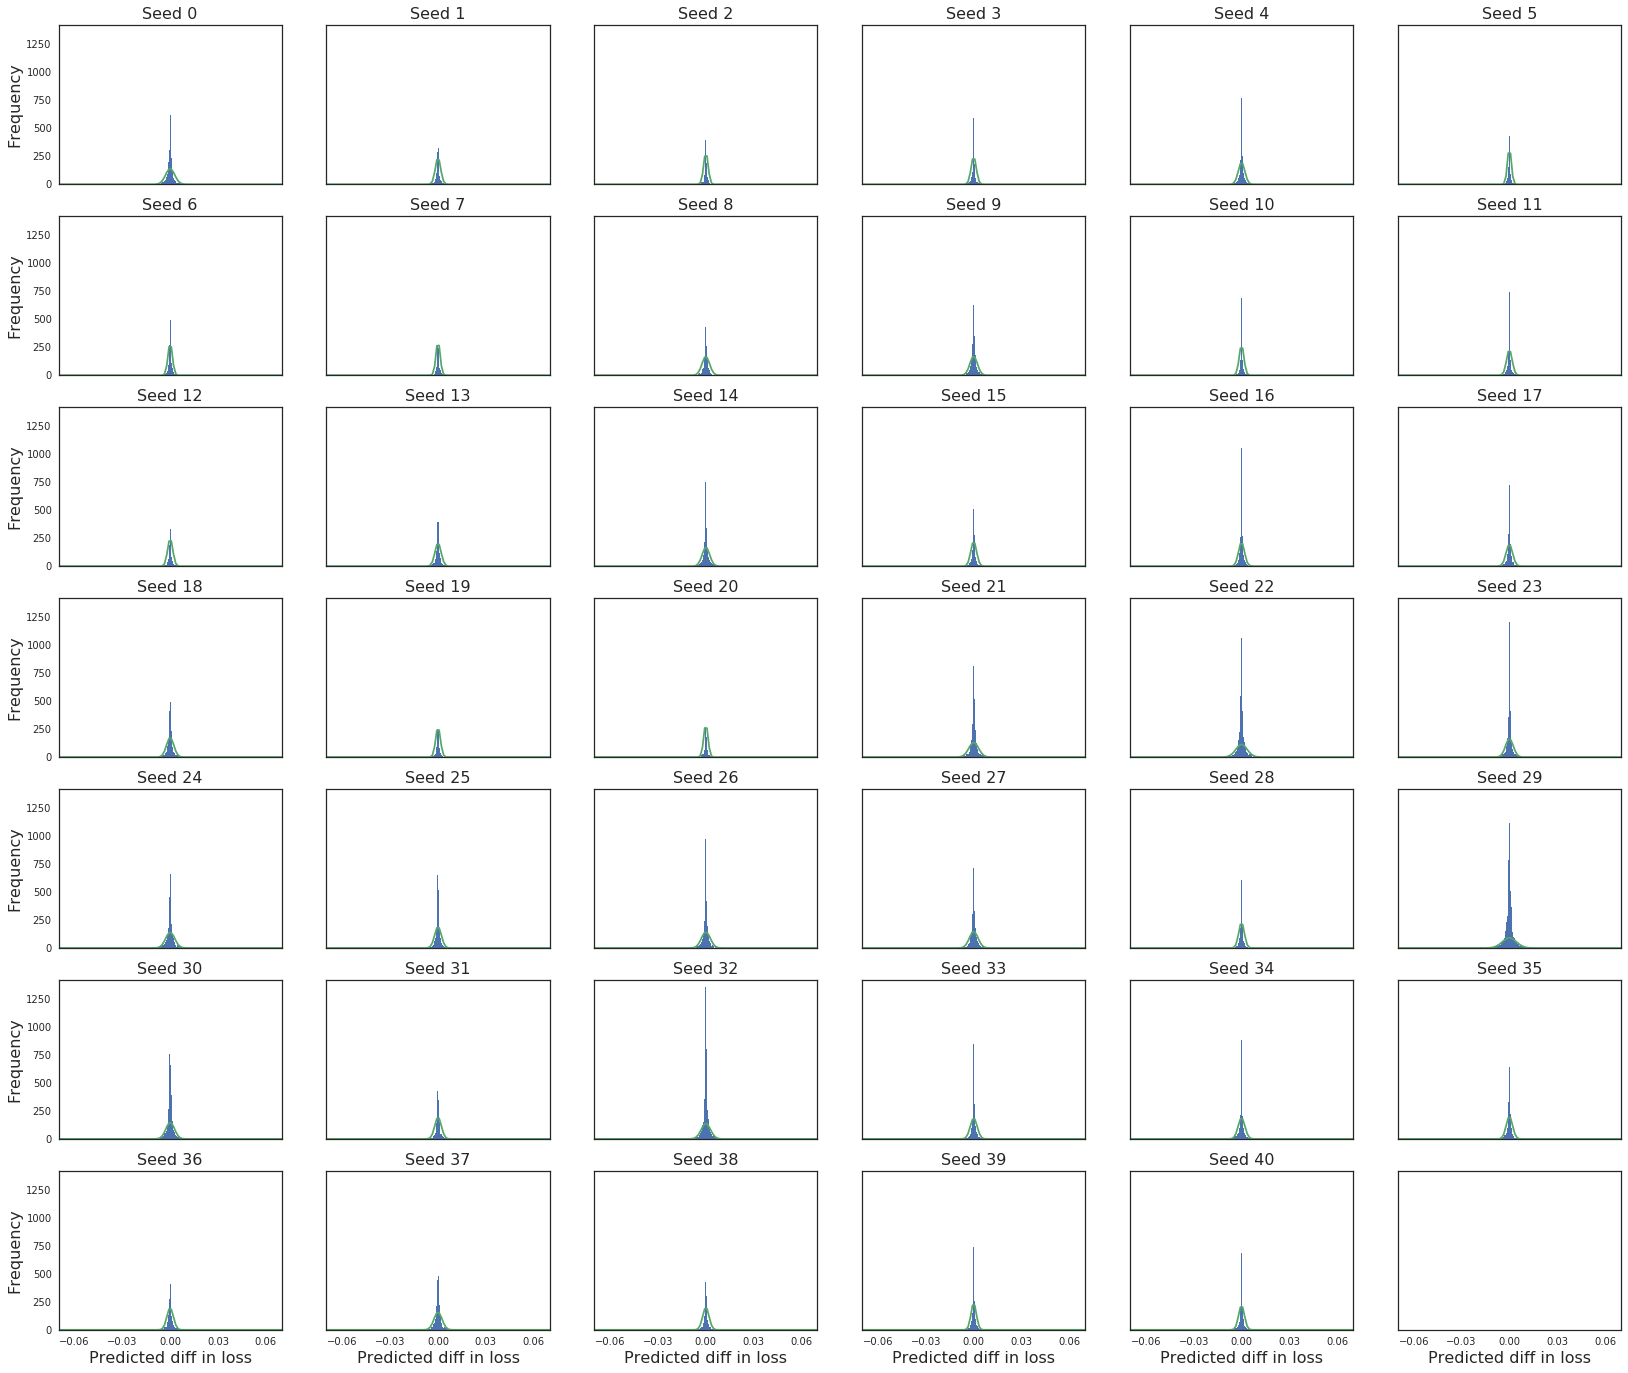

In [4]:
sns.set_style('white')
fontsize=16
width = 6
height = ceil_divide(num_seeds,width)
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(4*height, 4*width))

for row in axs: 
    row[0].set_ylabel('Frequency', fontsize=fontsize)
    for ax in row:
        ax.set_aspect('auto')
        ax.set_xticks(np.arange(-0.06, 0.07, 0.03))
        #ax.set_yticks()
        ax.set_xlim([-0.07, 0.07])
        #ax.set_ylim()
for col in axs[-1]:
    col.set_xlabel('Predicted diff in loss', fontsize=fontsize)
    
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        seed = len(row)*i+j
        if seed < num_seeds:
            ax.hist(predicted_loss_diffs_ordered[seed], bins=300)
            xmin, xmax = ax.get_xlim()
            x = np.linspace(xmin, xmax, 100)
            y = norm.pdf(x, means[seed], stddevs[seed])
            ax.plot(x, y)
            ax.set_title('Seed {}'.format(seed), fontsize=fontsize)

plt.savefig('../../scr/figs/hidden2_infl_freq_per_seed.png', dpi=600, bbox_inches='tight')

457


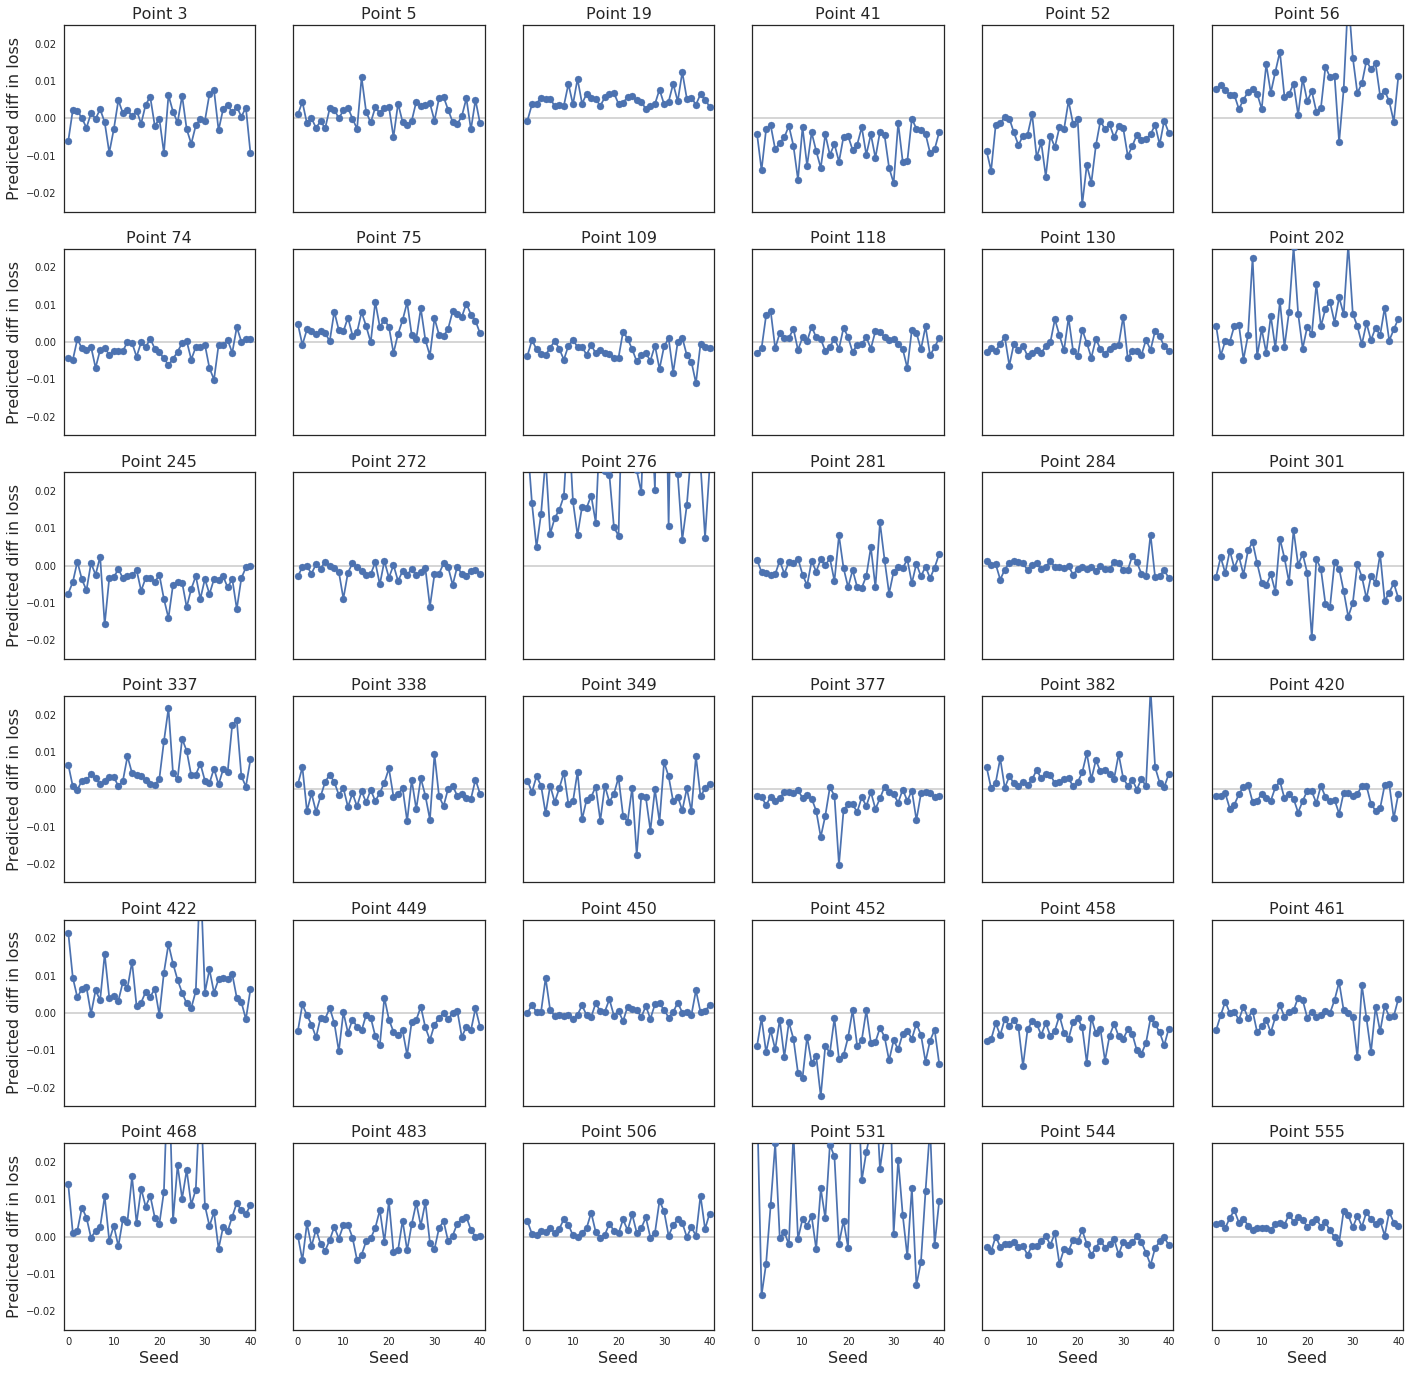

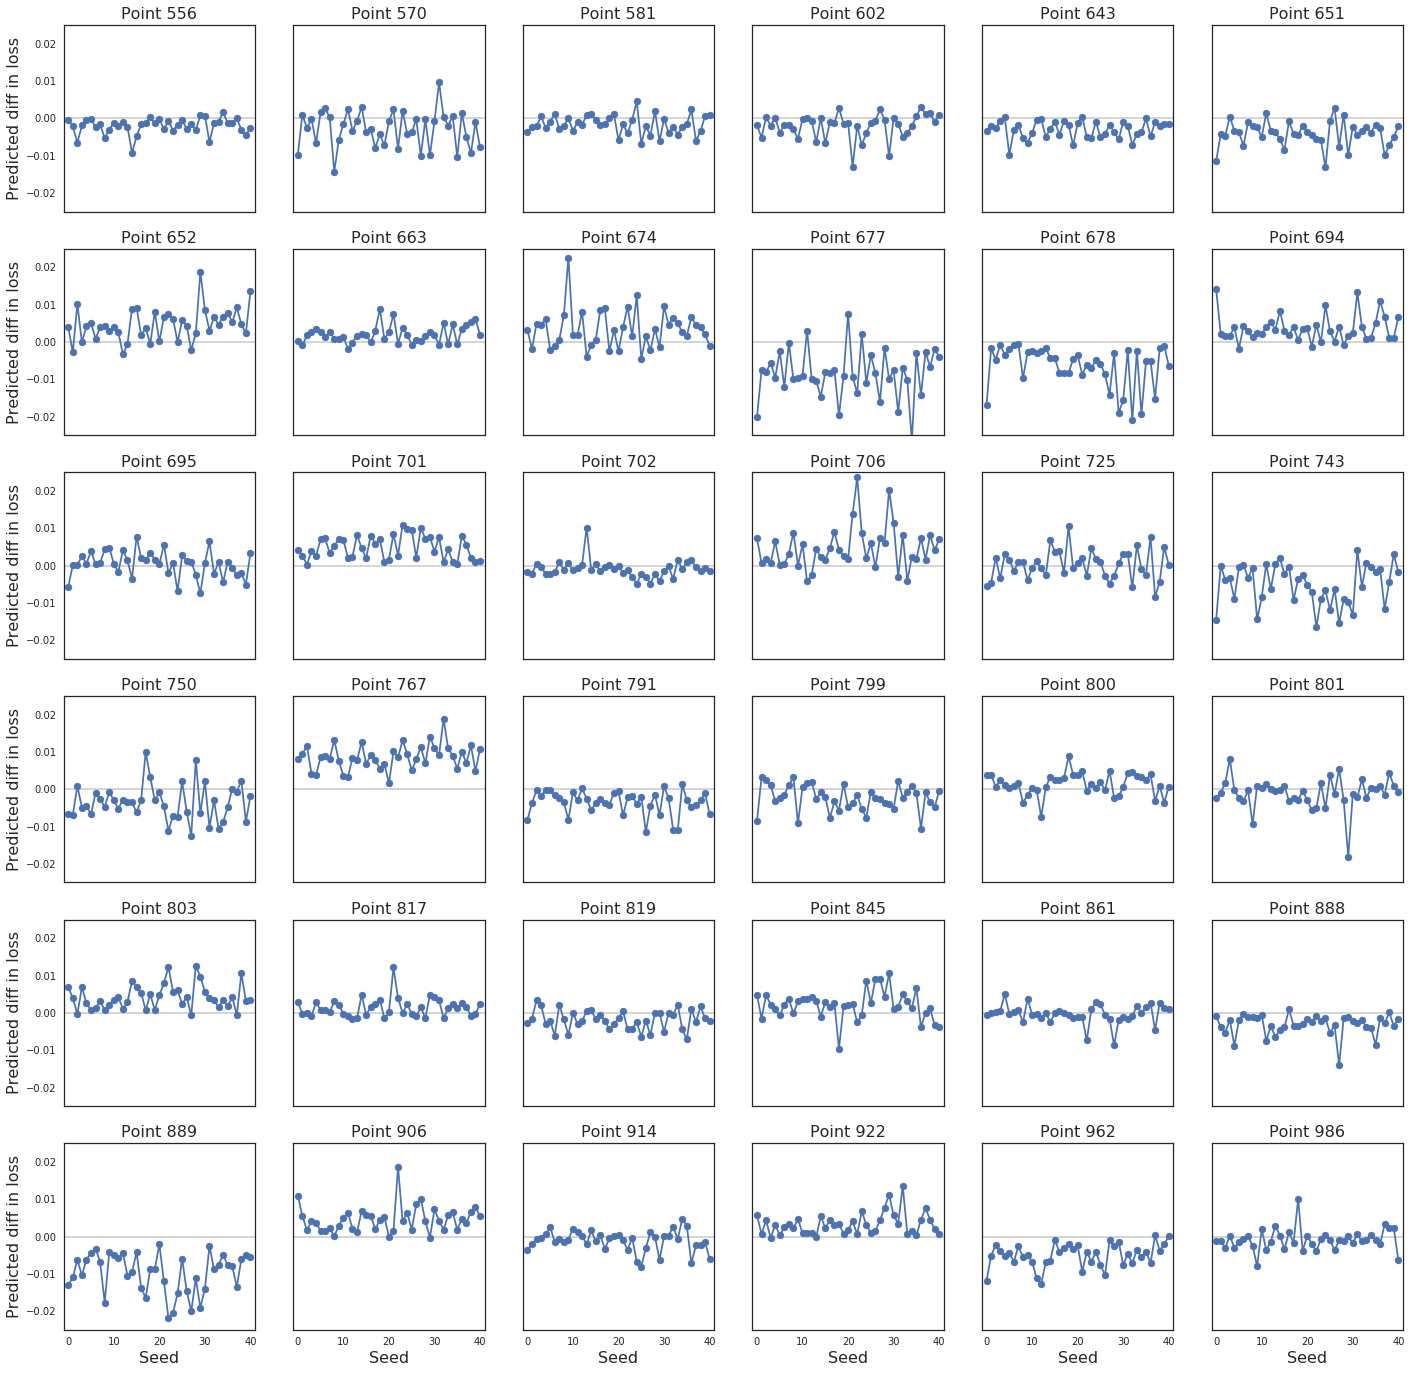

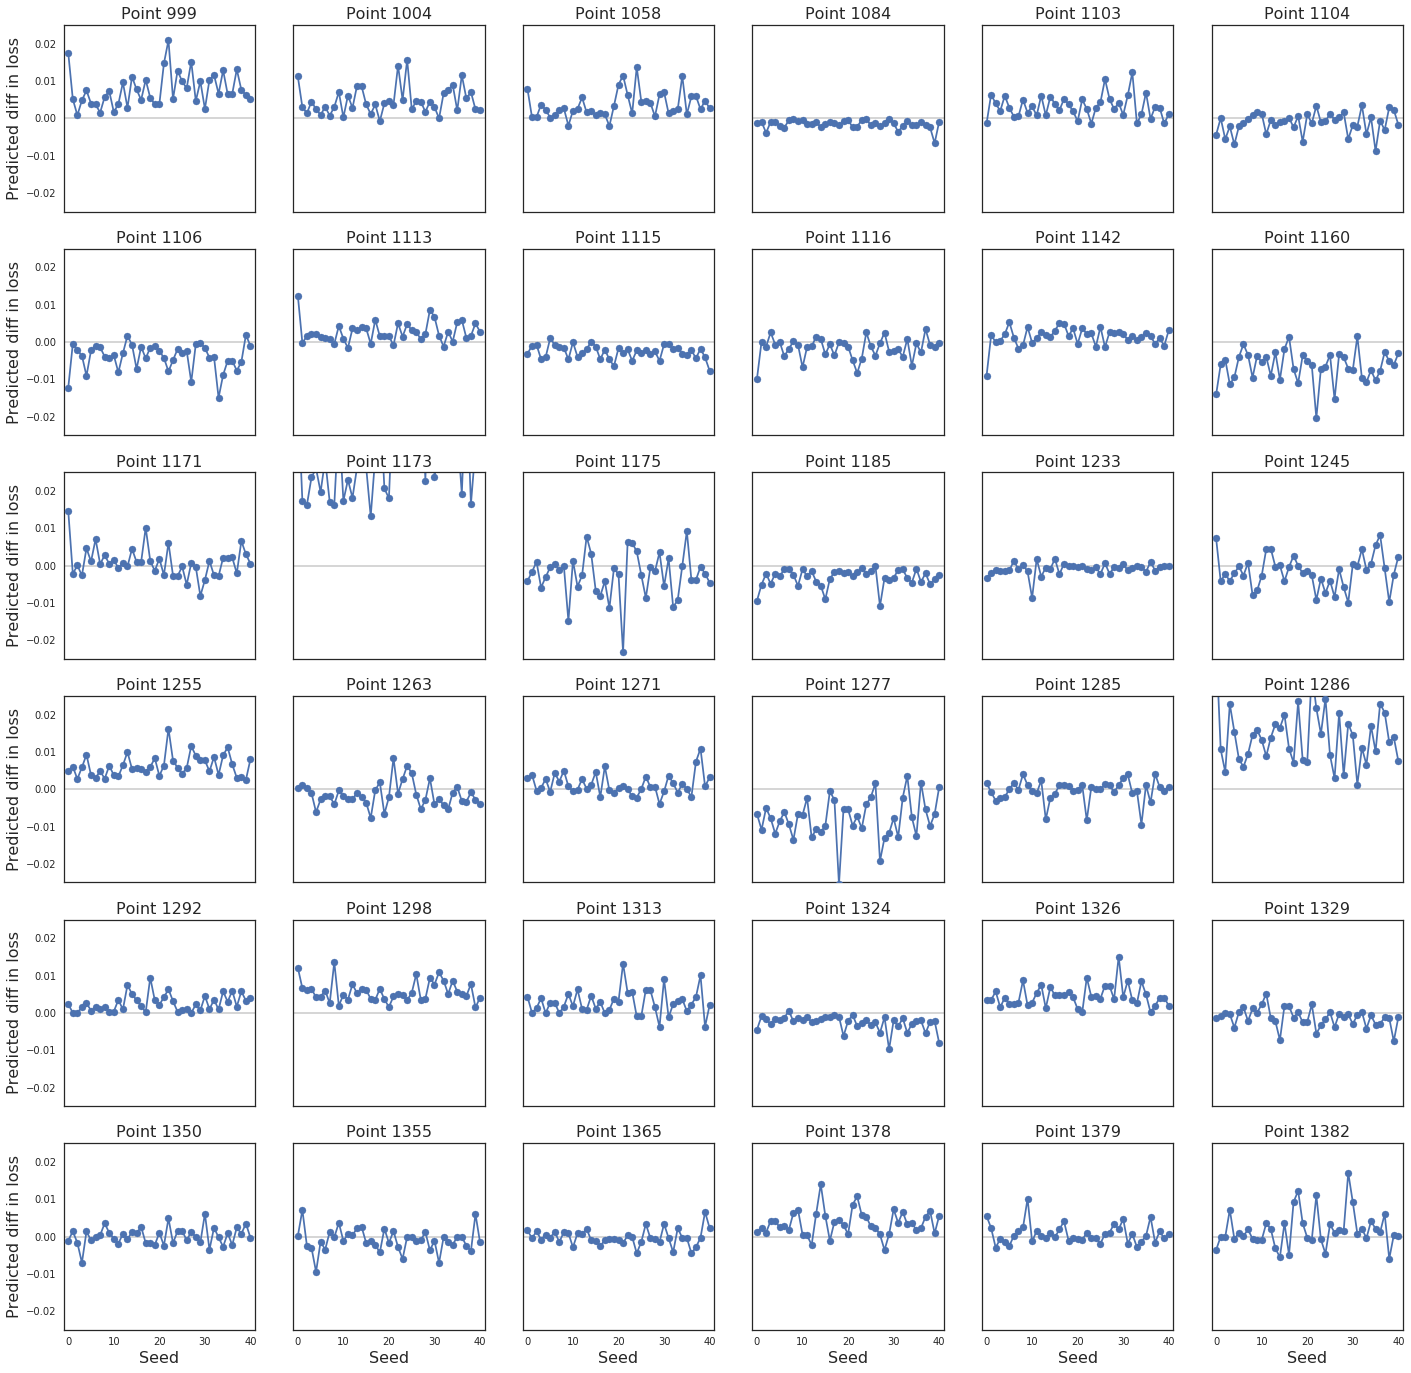

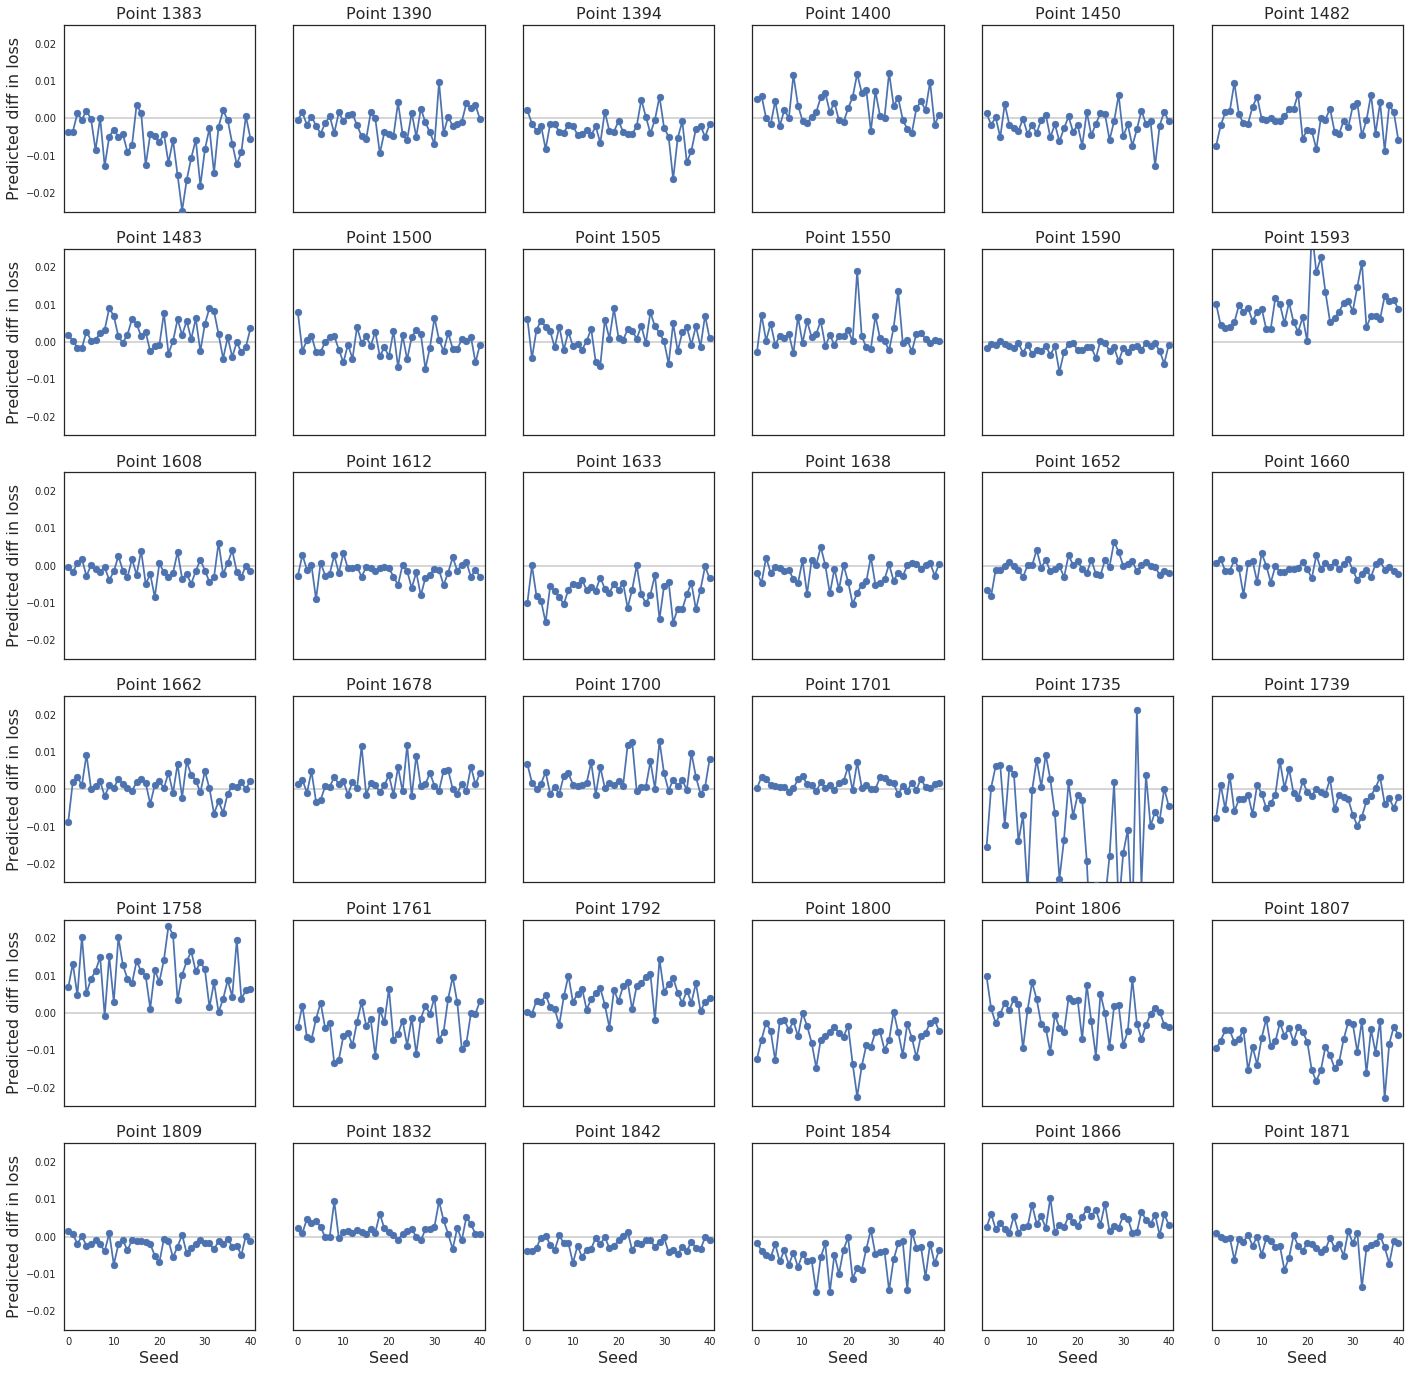

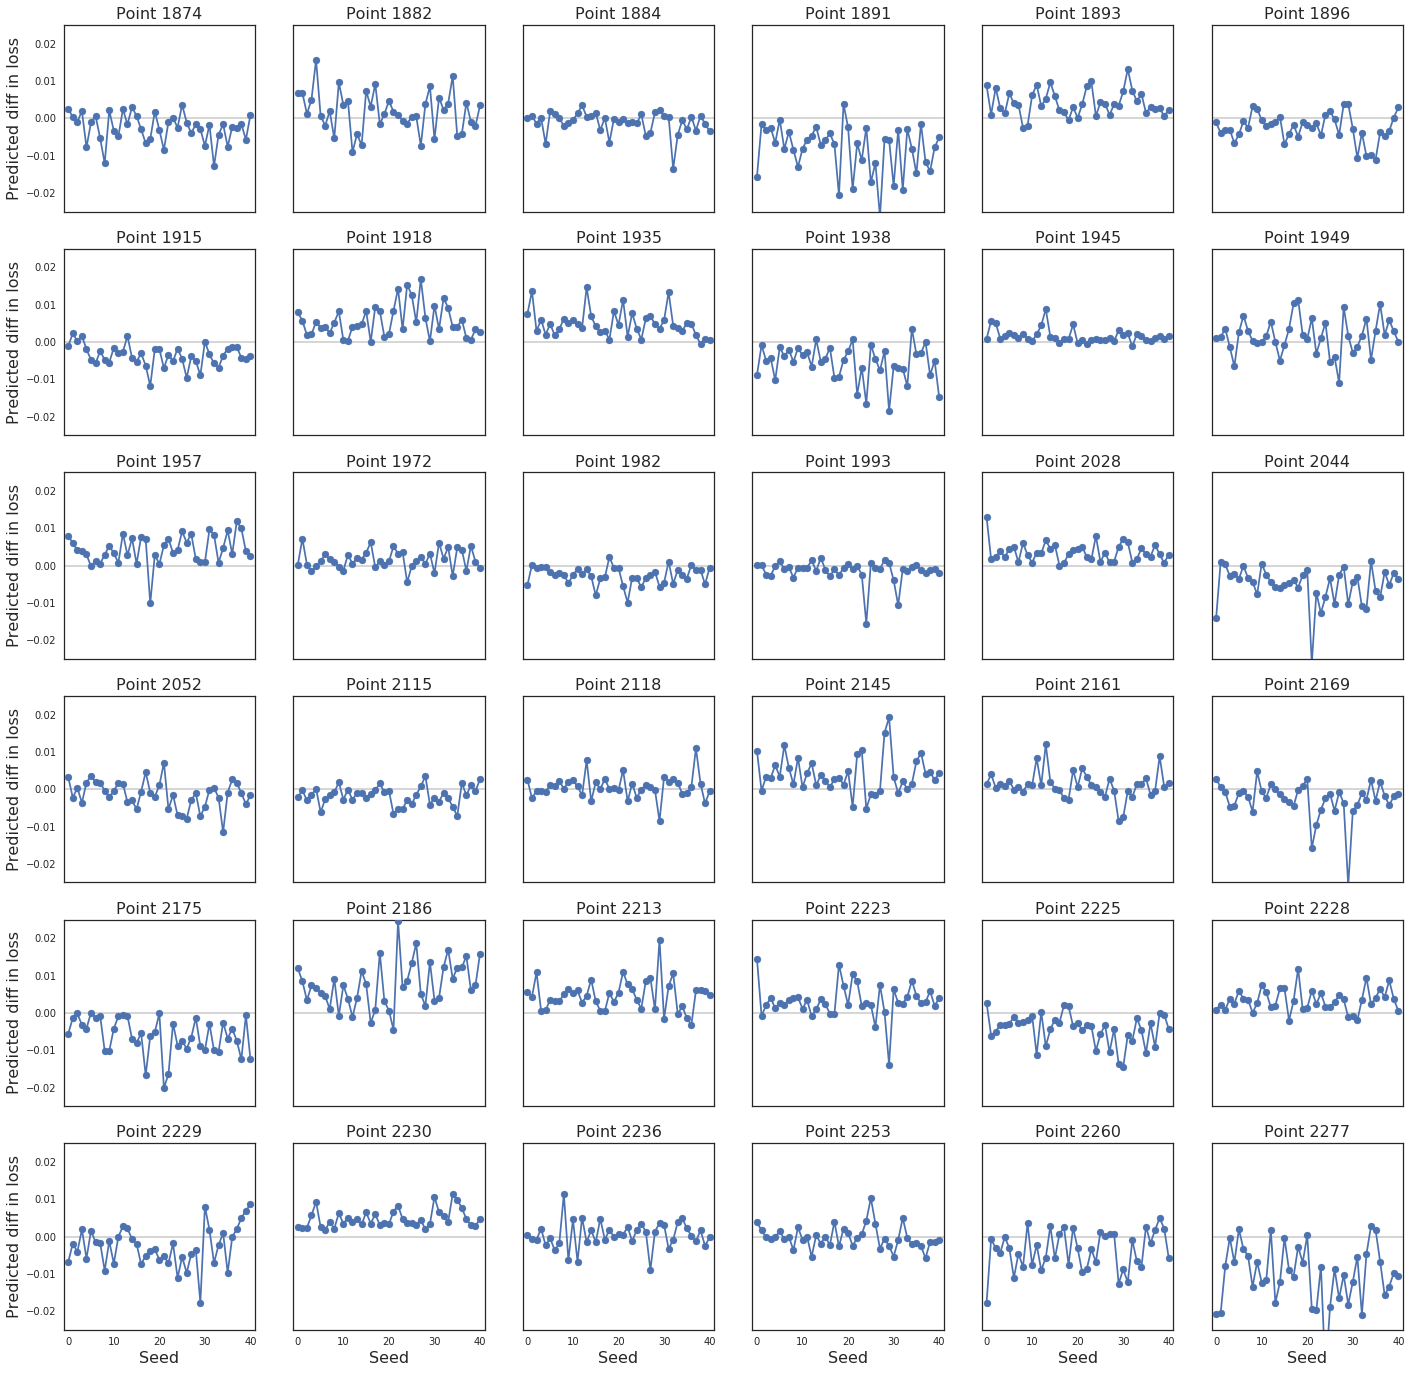

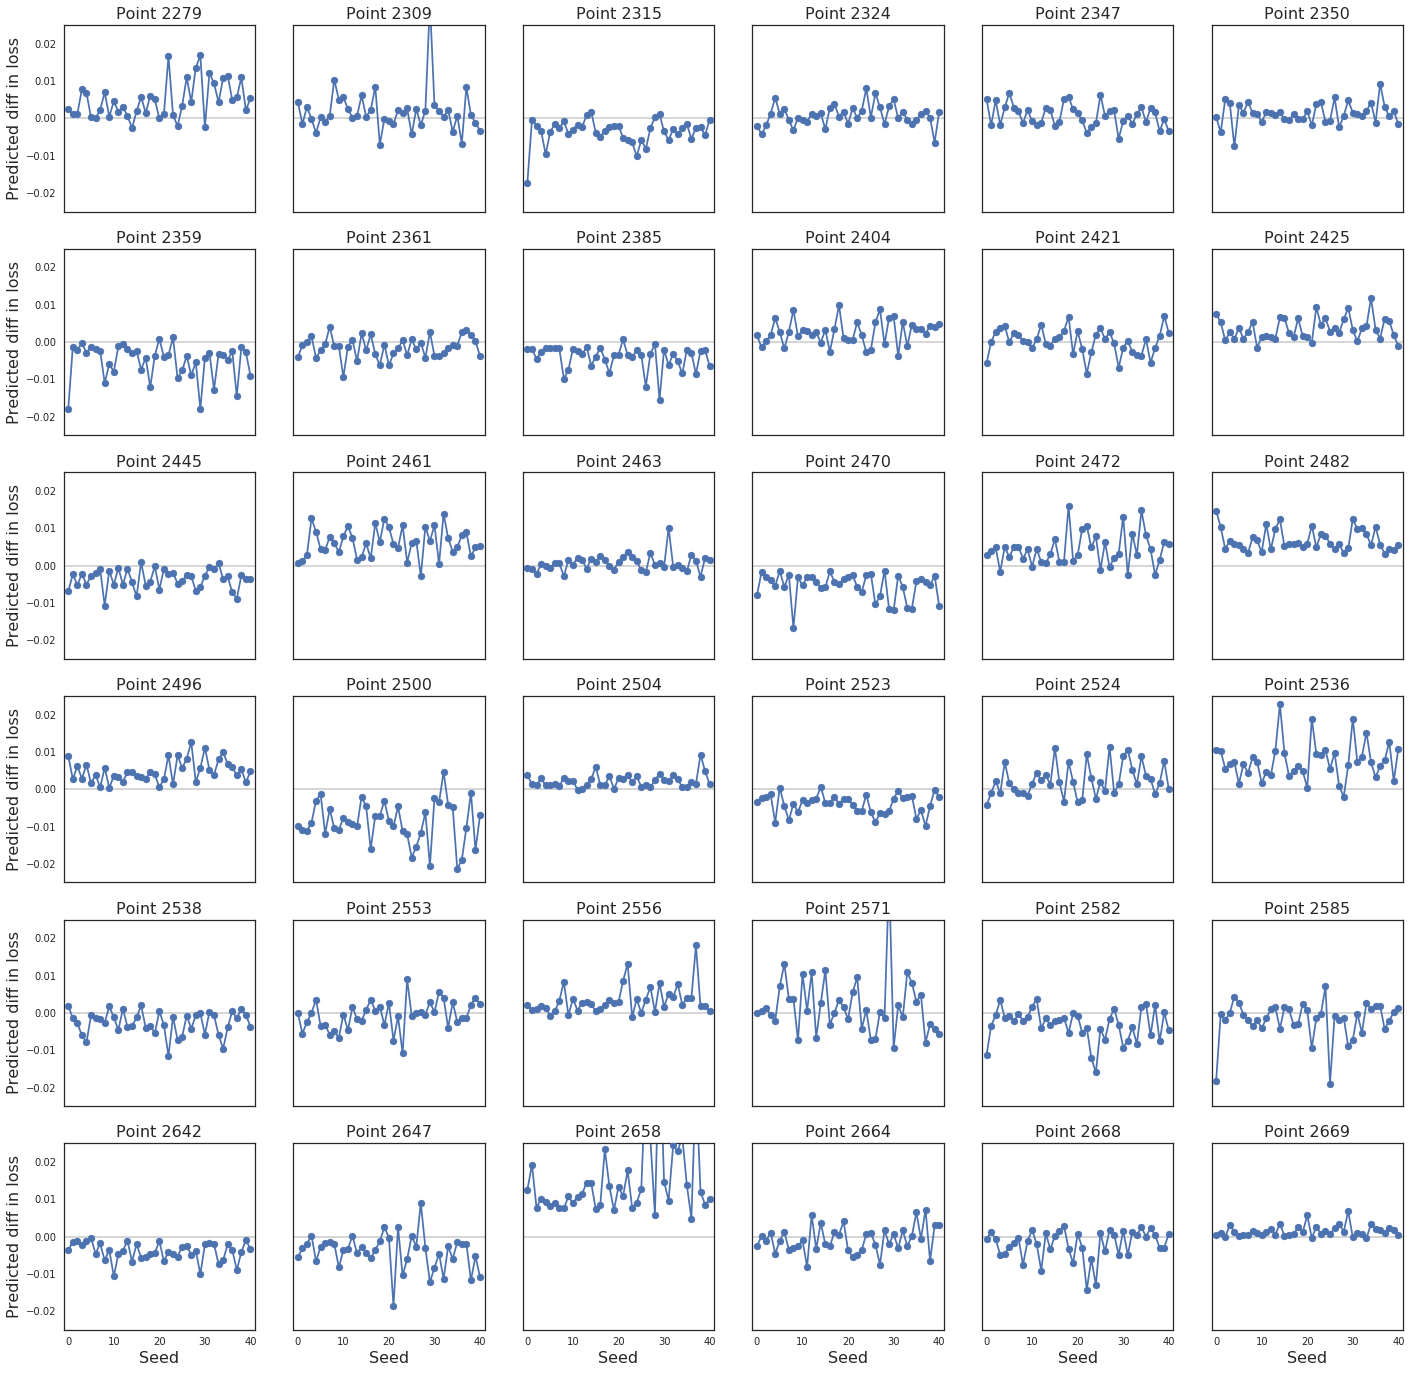

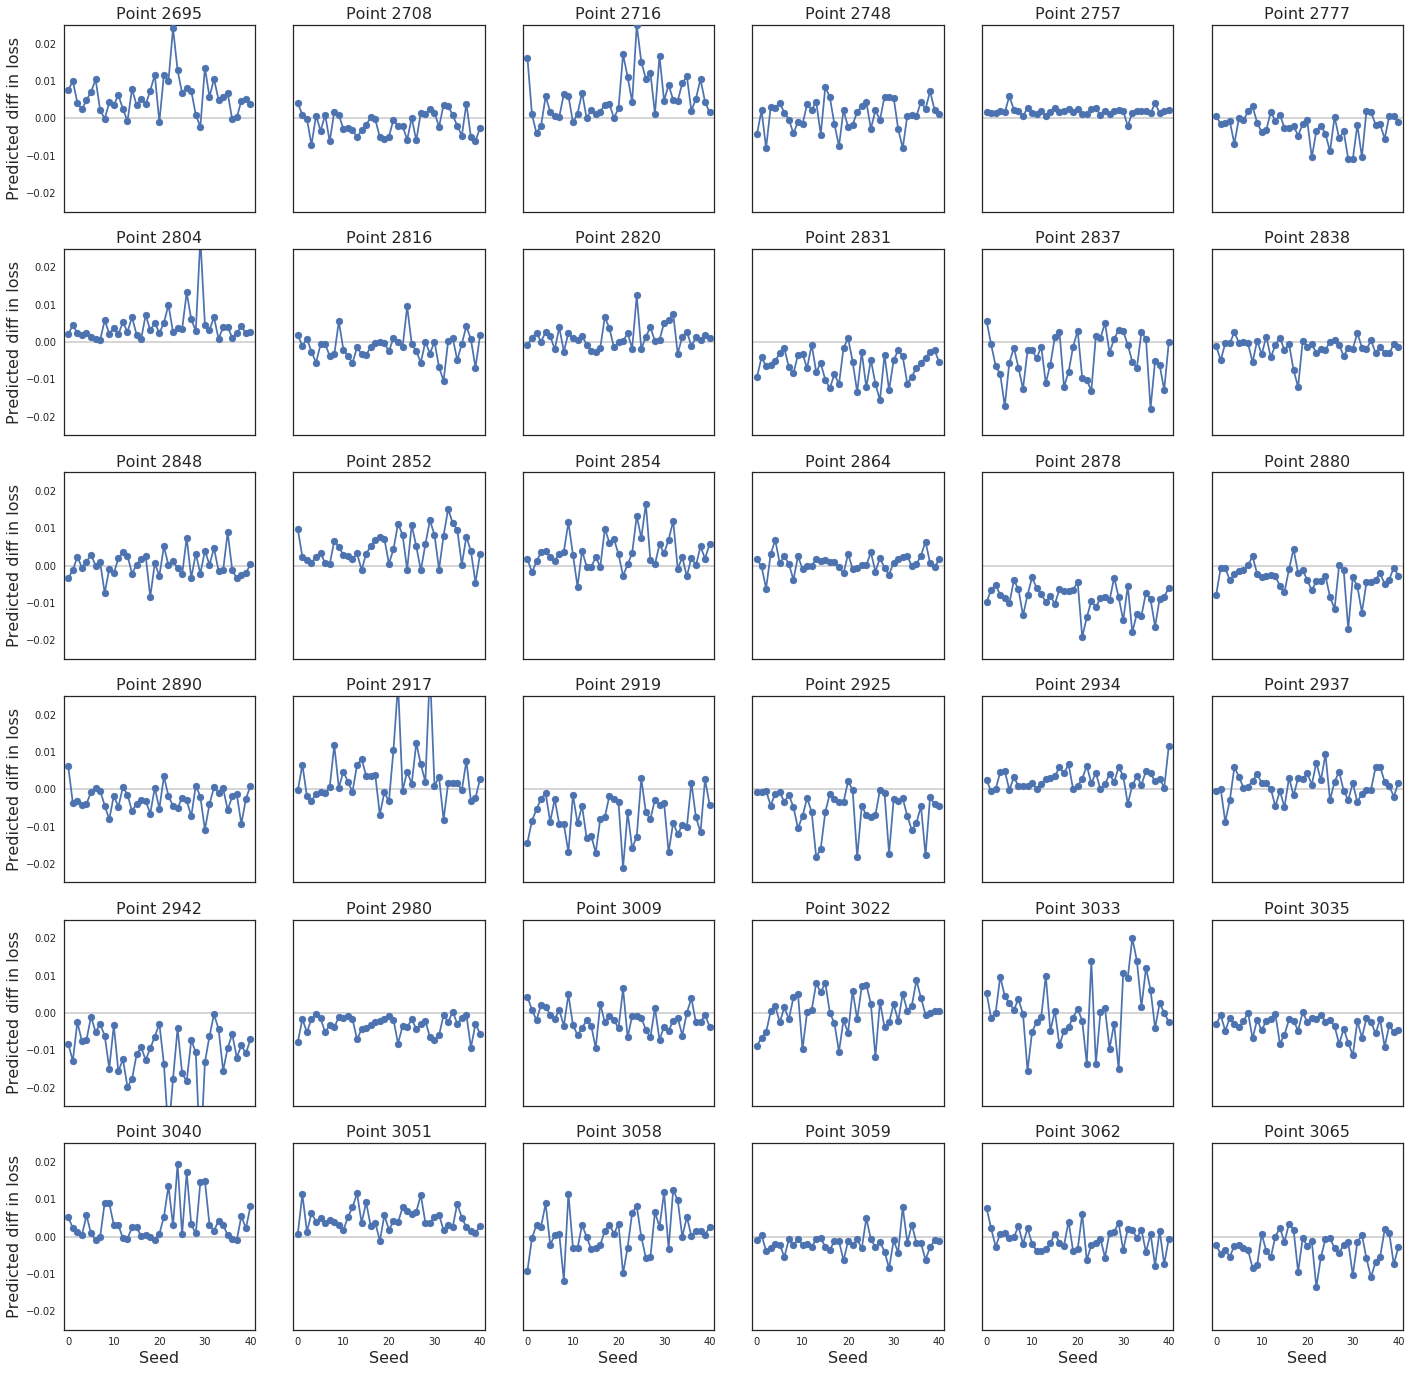

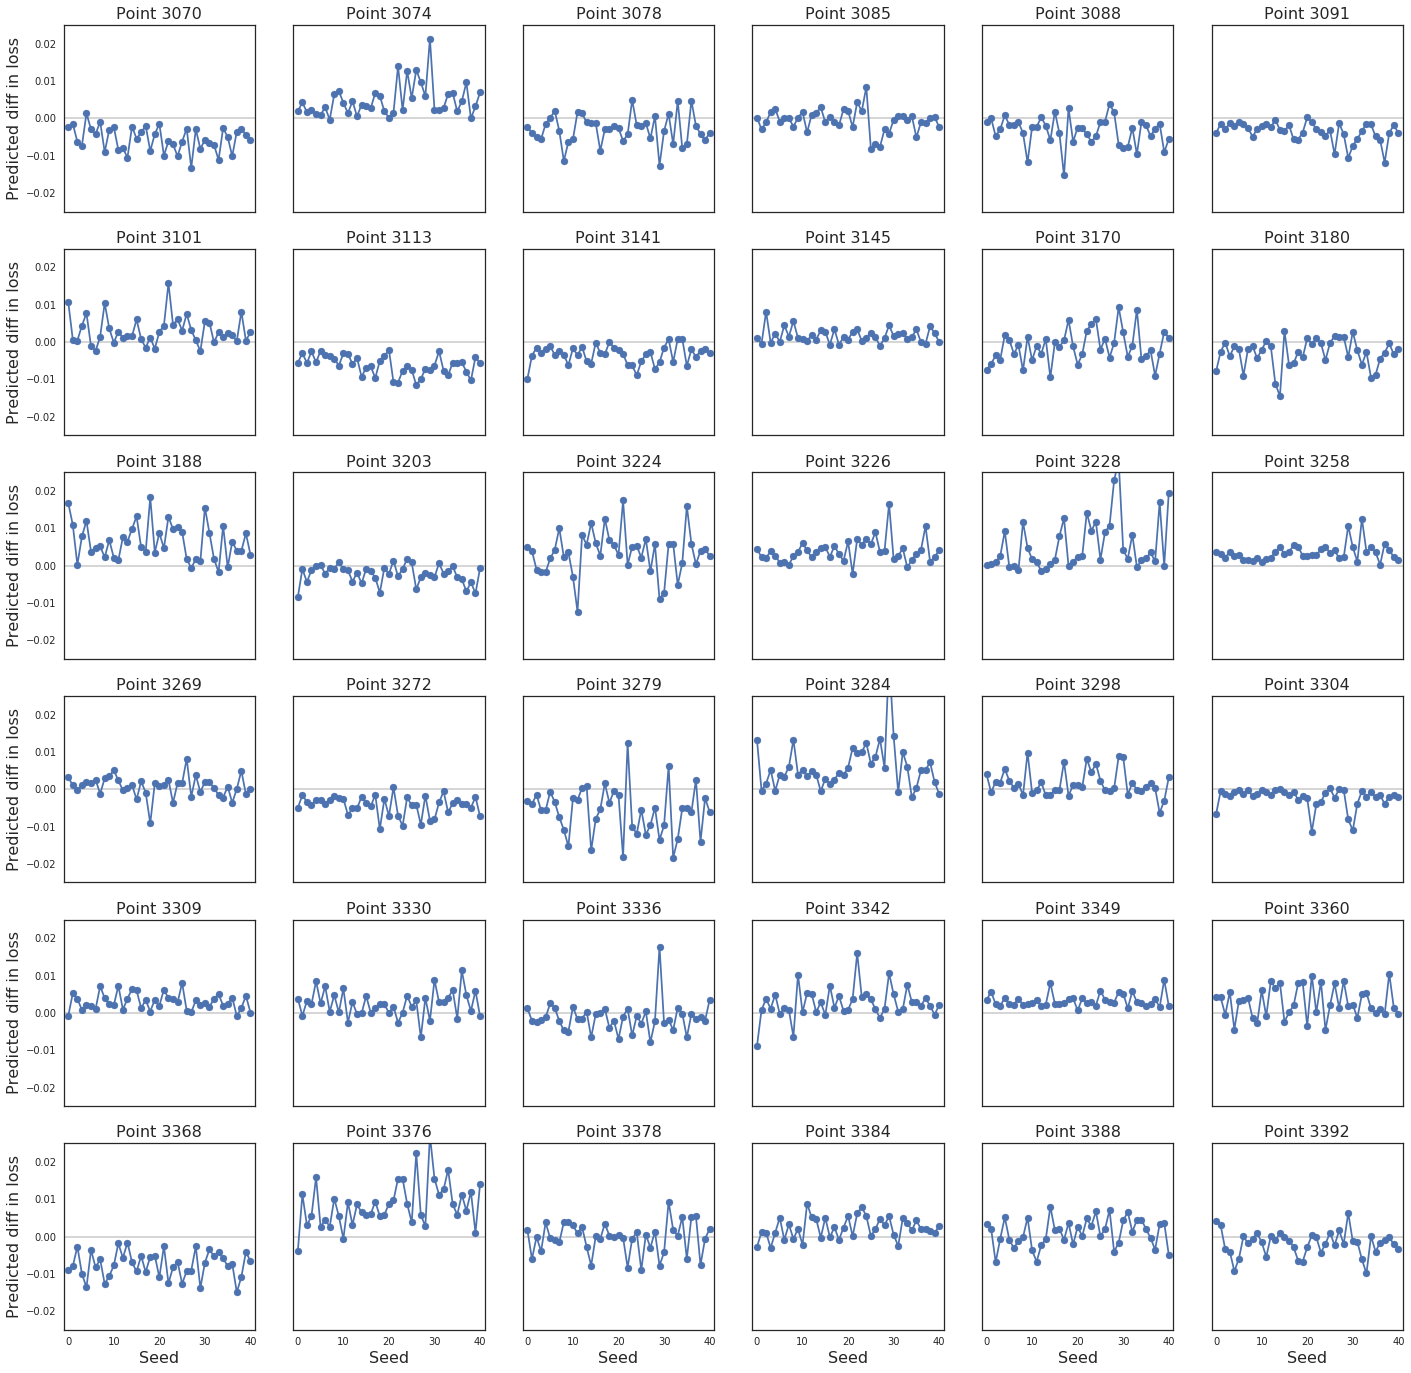

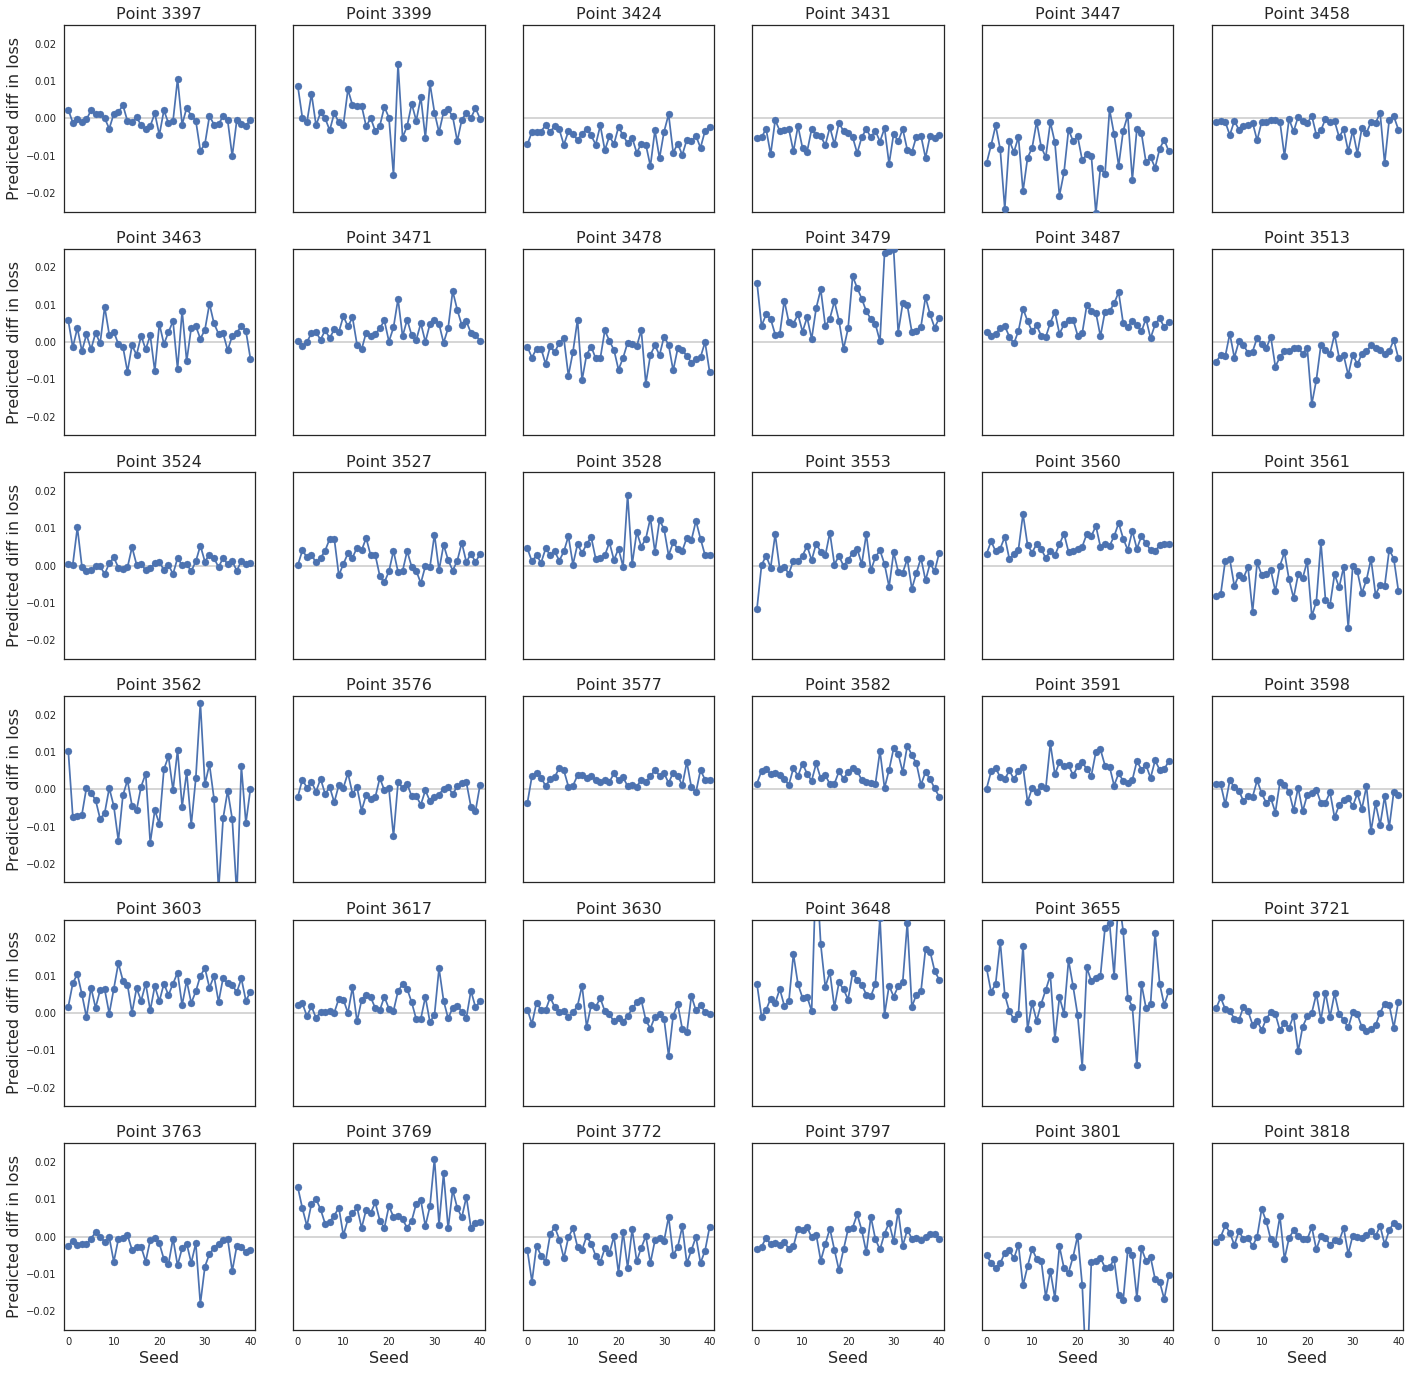

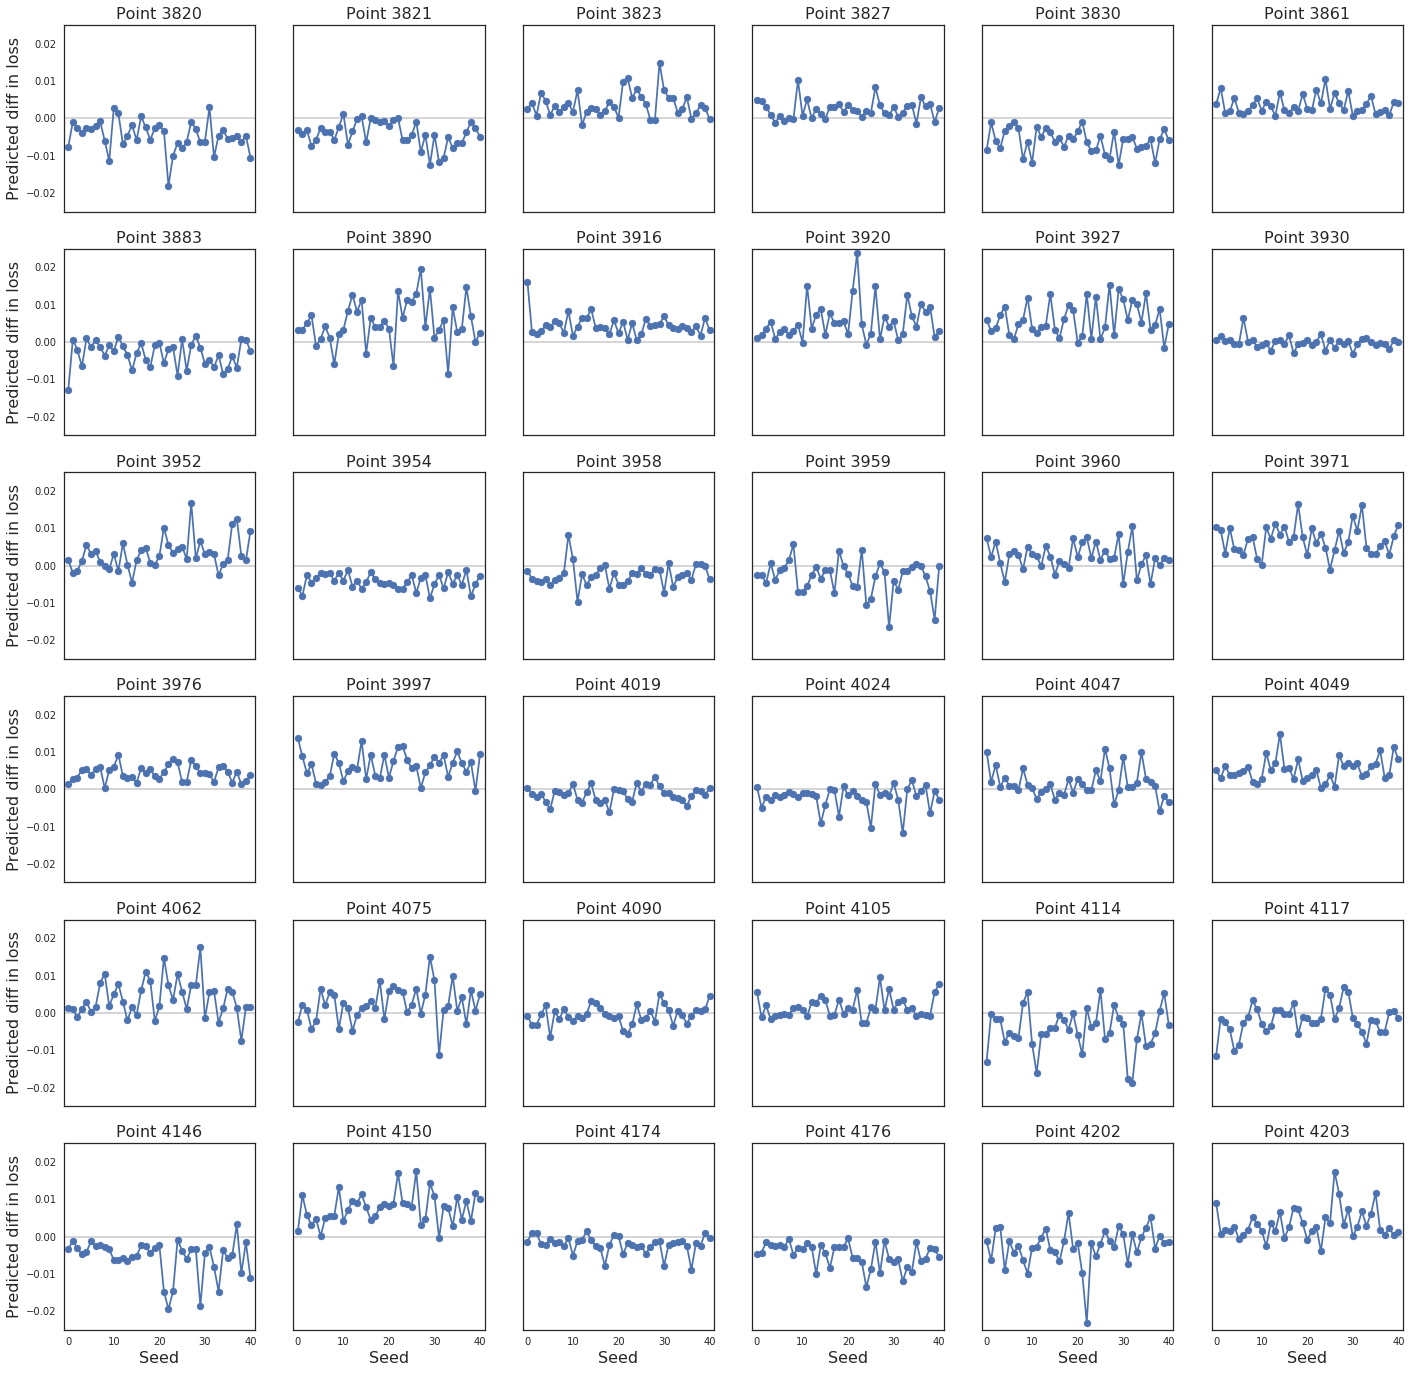

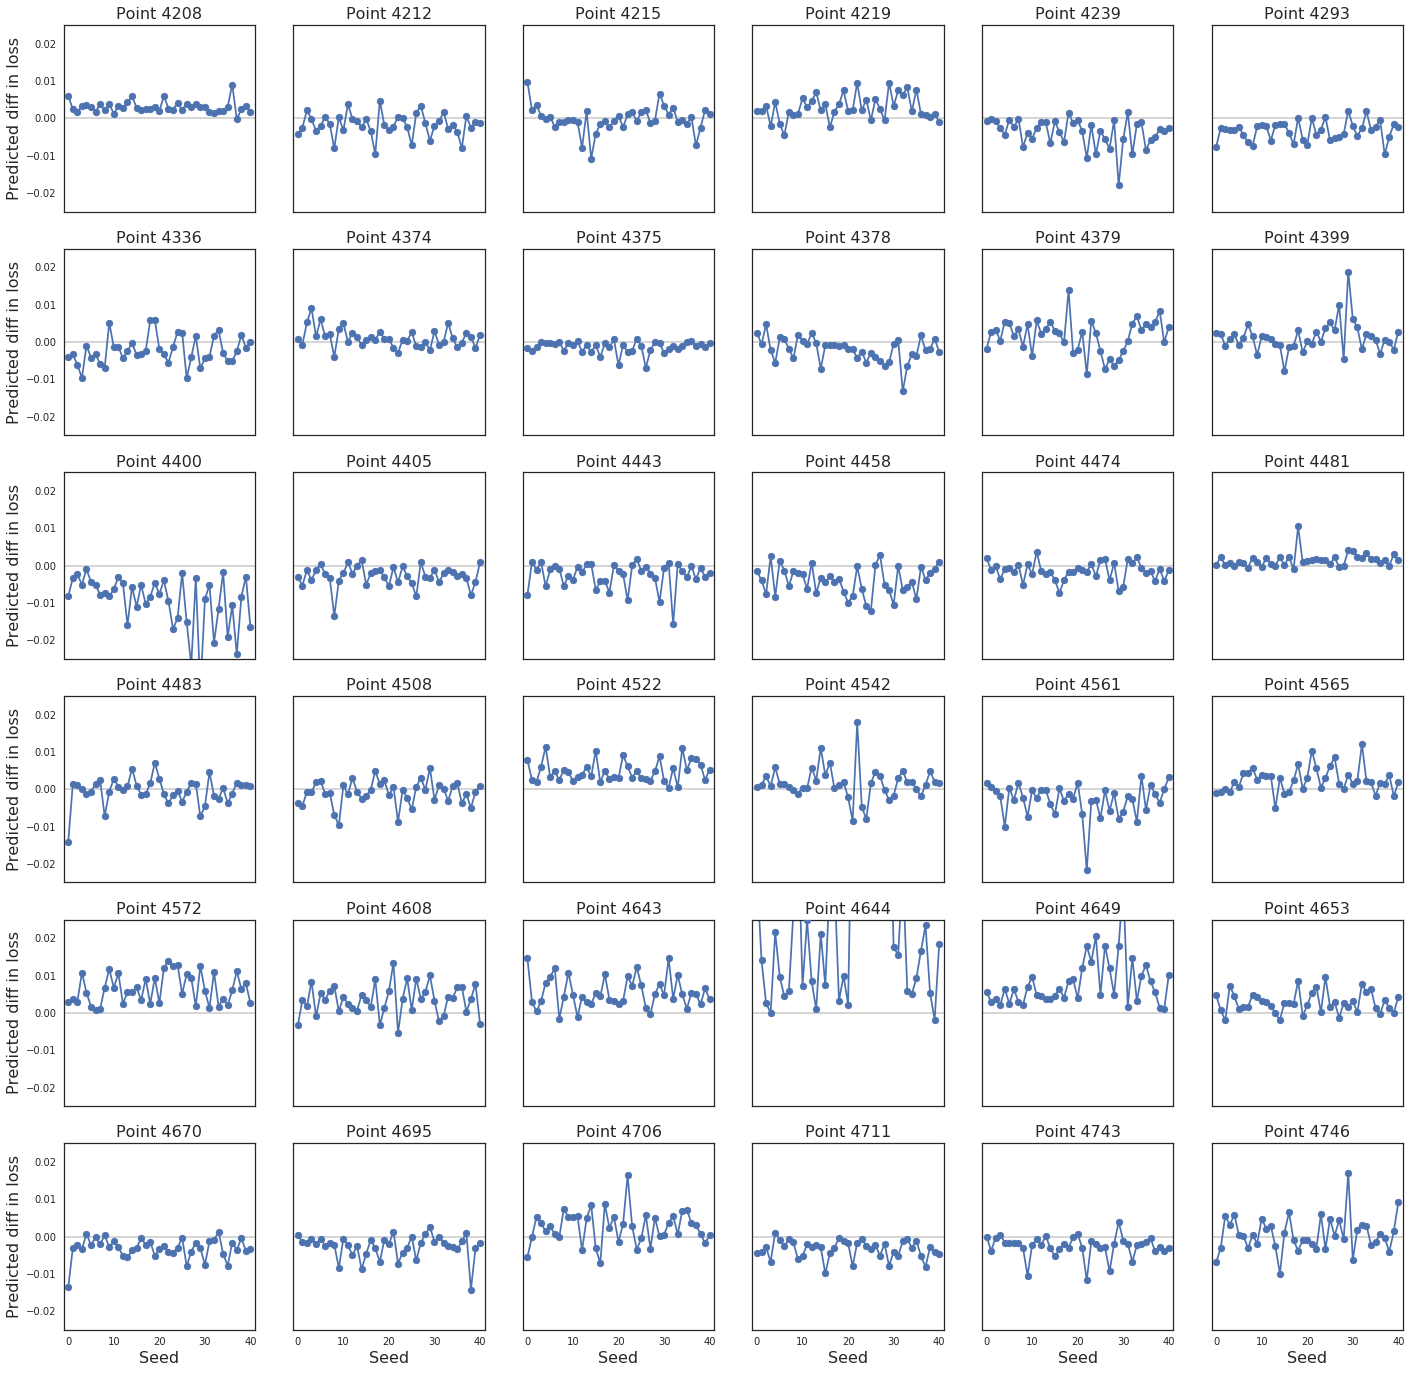

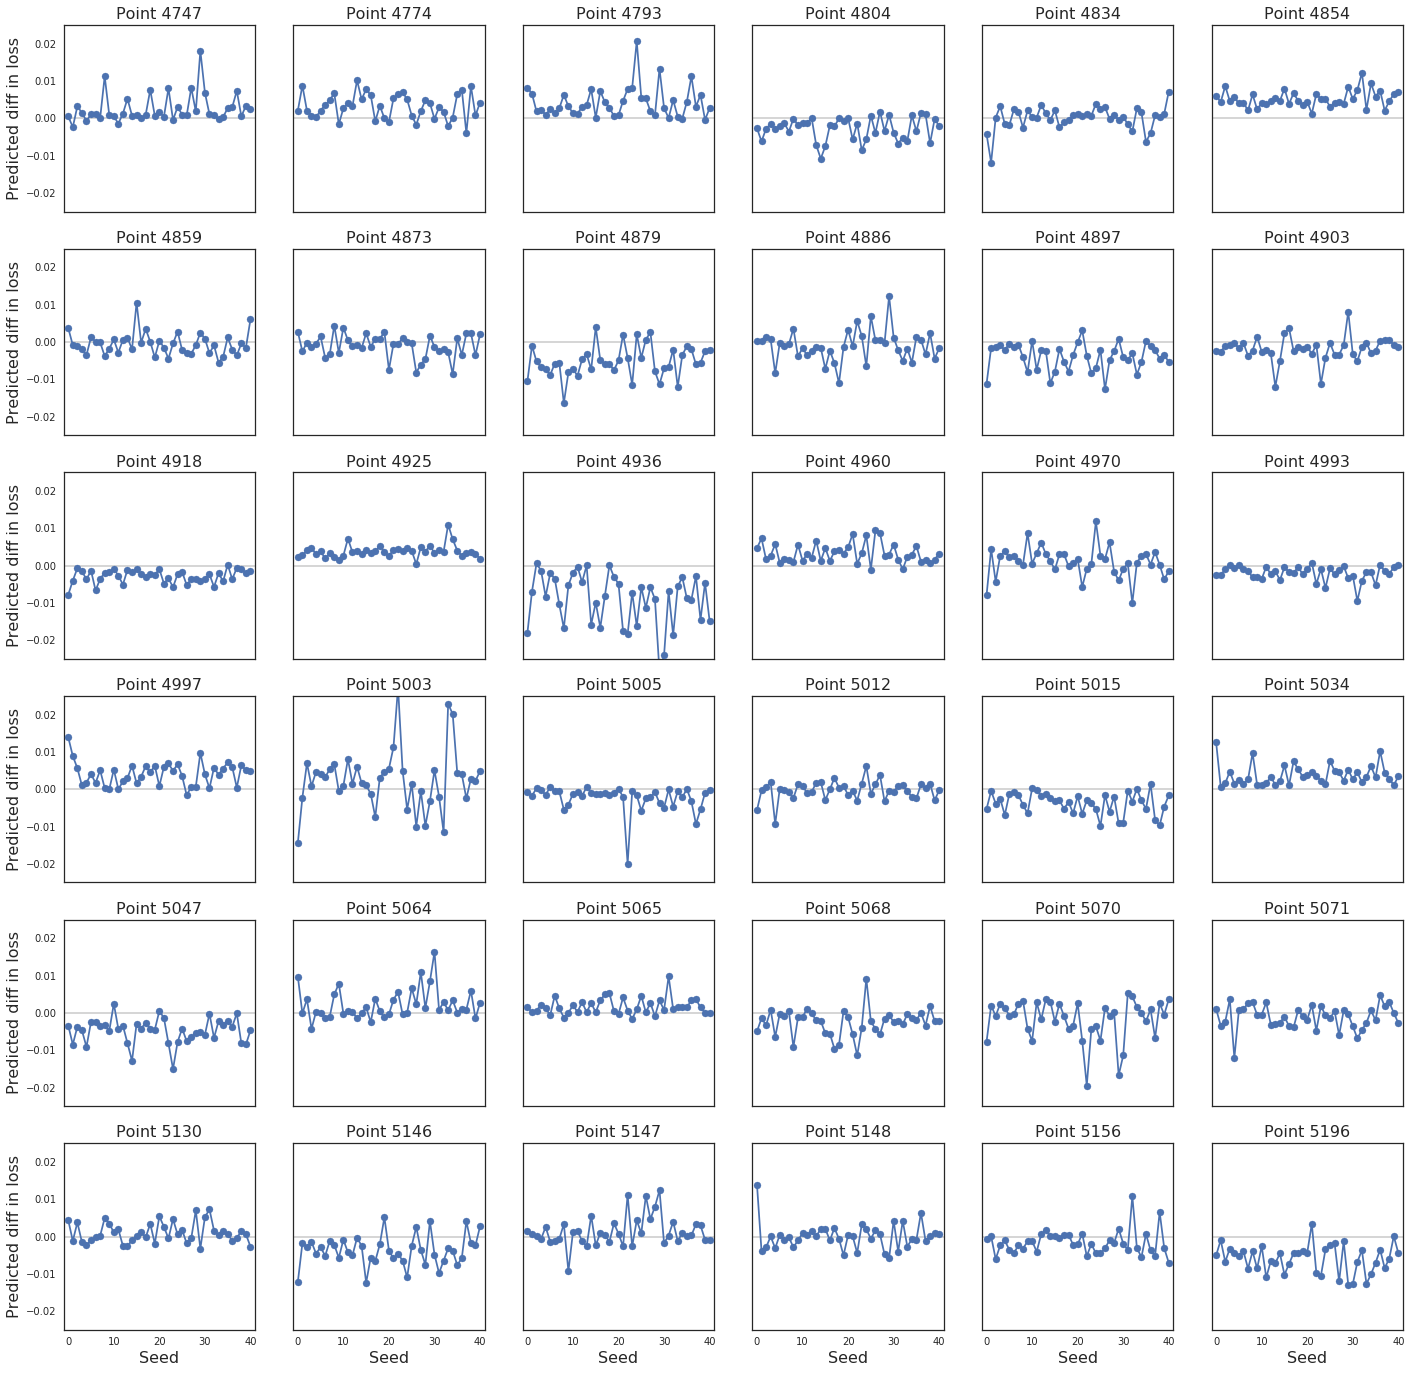

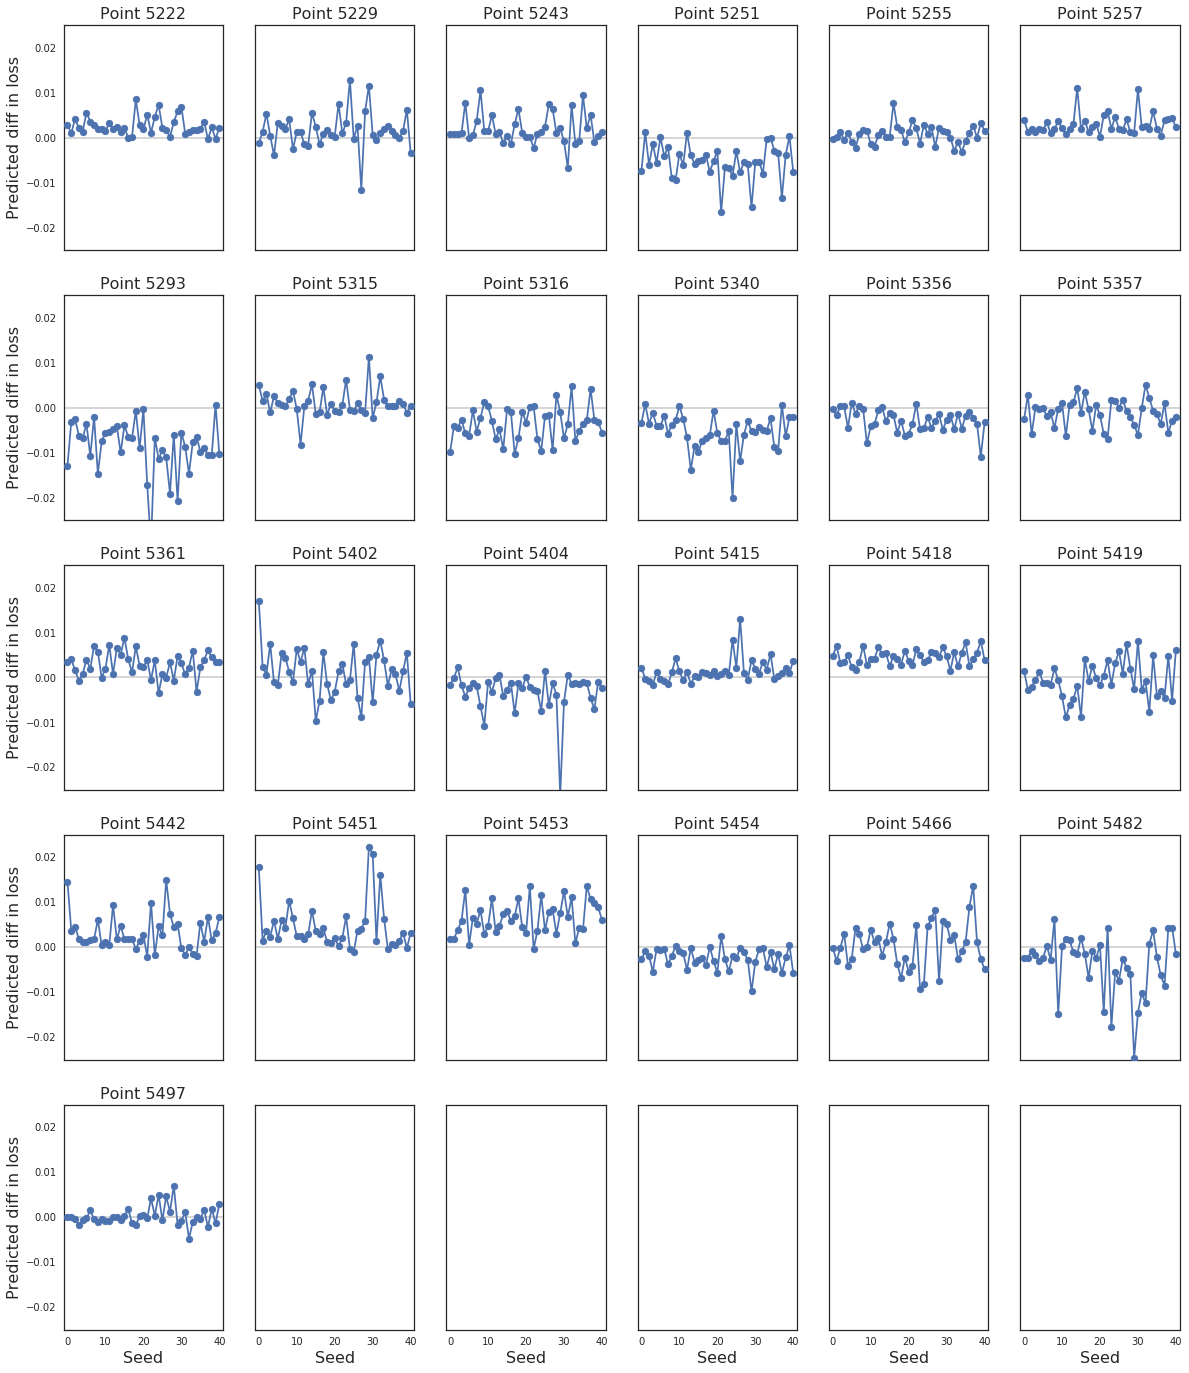

In [5]:
#776 when top 100
#457 when top 50
print(len(influential_indices))
num_groups = ceil_divide(len(influential_indices),group_sz)

for group in range(num_groups):
    sns.set_style('white')
    fontsize=16
    width = 6

    if style == "top_infl":
        num_points = group_sz if group != num_groups - 1 else len(influential_indices) % group_sz
        height = ceil_divide(num_points,width)
        point_ids = influential_indices[group * group_sz : group * group_sz + num_points]
    if style == "random":
        height = 6
        num_points = height * width
        point_ids = np.random.choice(len(predicted_loss_diffs[0]),num_points)

    fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(4*height, 4*width))

    for row in axs: 
        row[0].set_ylabel('Predicted diff in loss', fontsize=fontsize)
        for ax in row:
            ax.set_aspect('auto')
            ax.set_xticks(np.arange(0, num_seeds, max(int(num_seeds/4),1)))
            ax.set_yticks(np.arange(-0.03, 0.04, 0.01))
            ax.set_xlim([-1,num_seeds])
            ax.set_ylim([-0.025, 0.025])
    for col in axs[-1]:
        col.set_xlabel('Seed', fontsize=fontsize)

    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            ind = len(row)*i+j
            if ind < num_points:
                point = point_ids[ind]
                ax.axhline(color='k',alpha=0.2,zorder=1)
                ax.plot(range(num_seeds), predicted_loss_diffs[:,point], zorder=2)
                ax.scatter(range(num_seeds), predicted_loss_diffs[:,point], zorder=3)
                ax.set_title('Point {}'.format(point), fontsize=fontsize)

    plt.savefig('../../scr/figs/hidden2_infl_per_point_{}_group{}.png'.format(style, group), dpi=600, bbox_inches='tight')

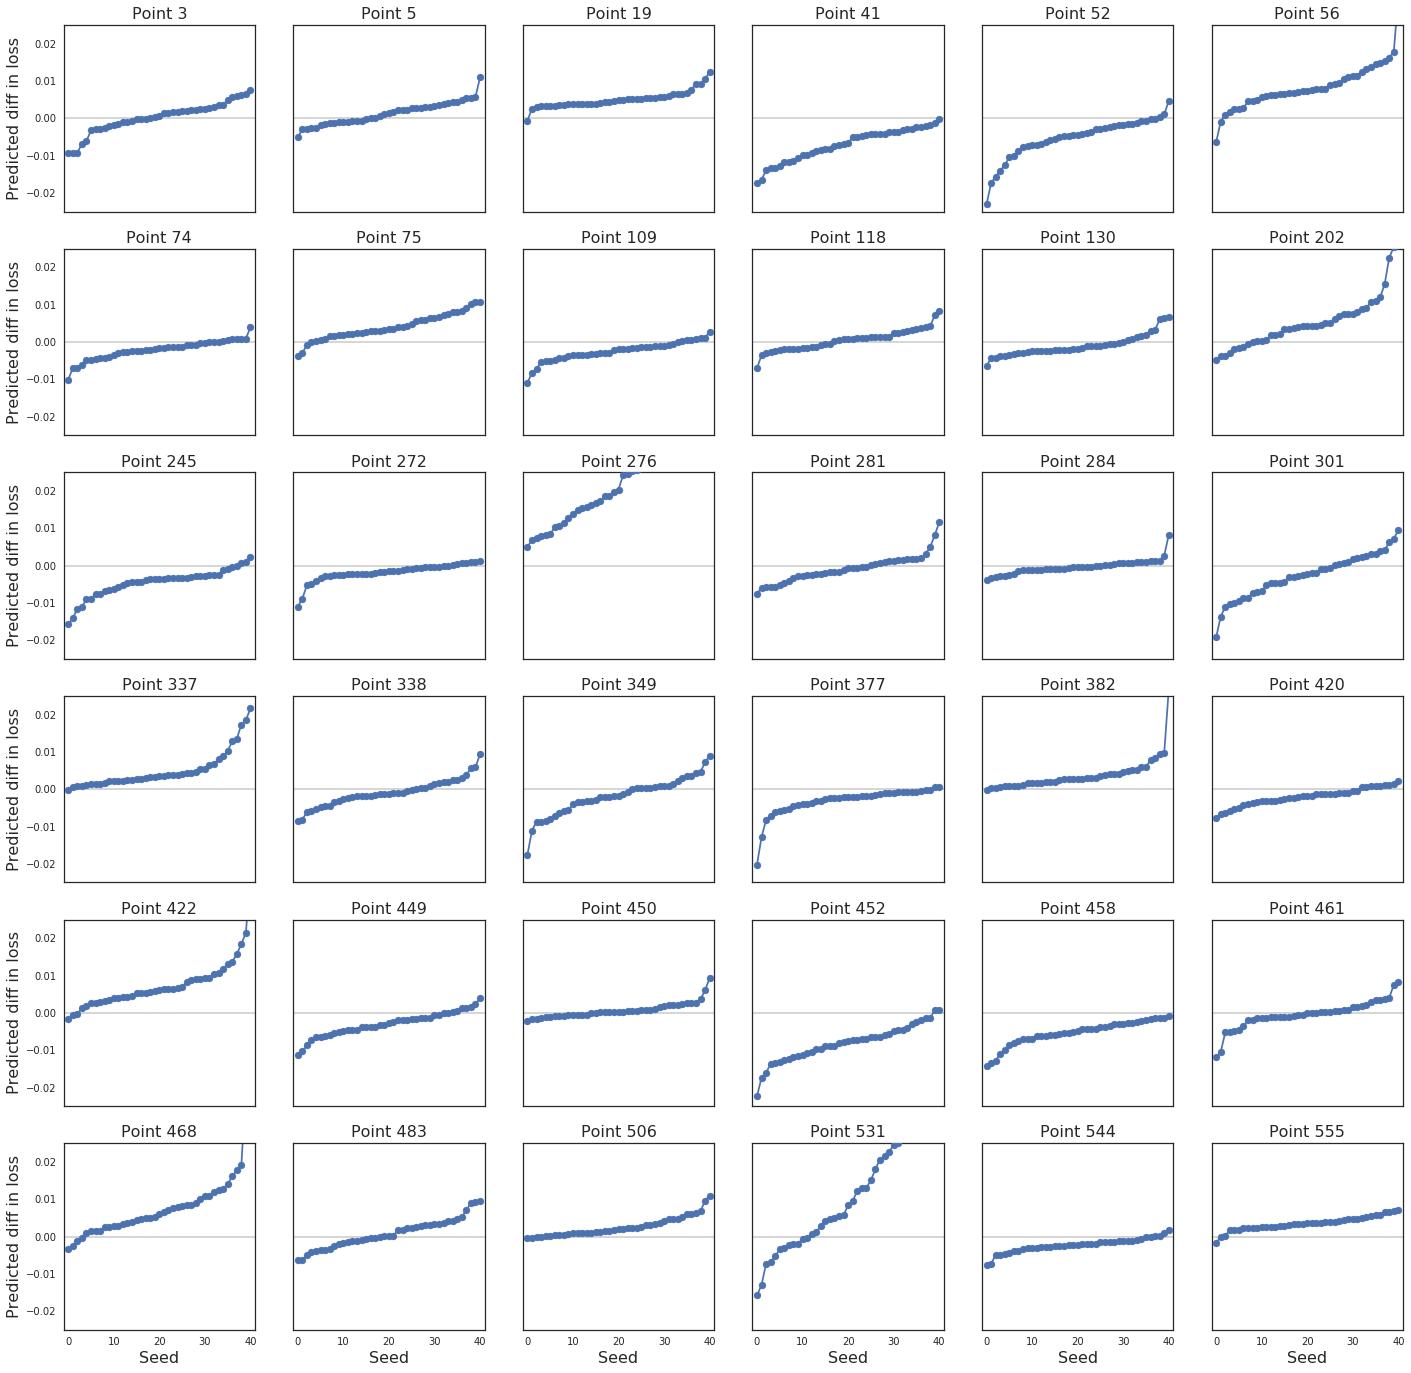

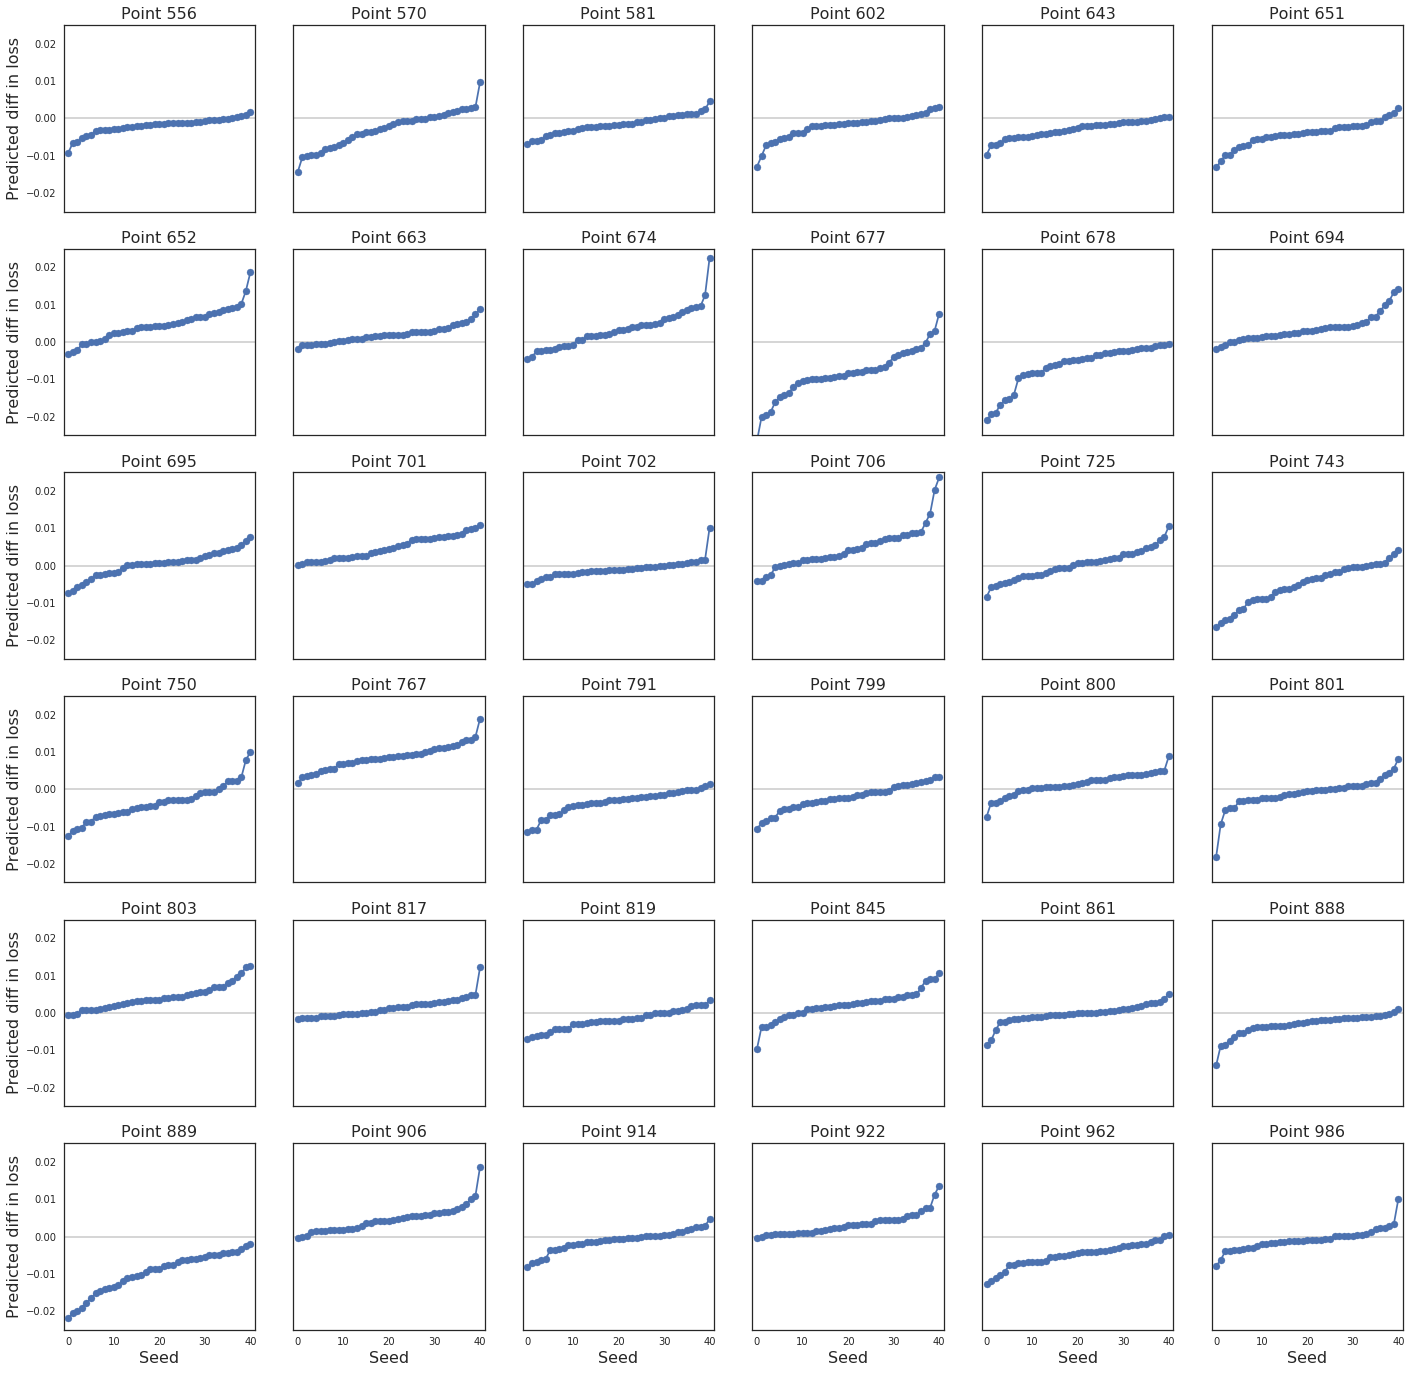

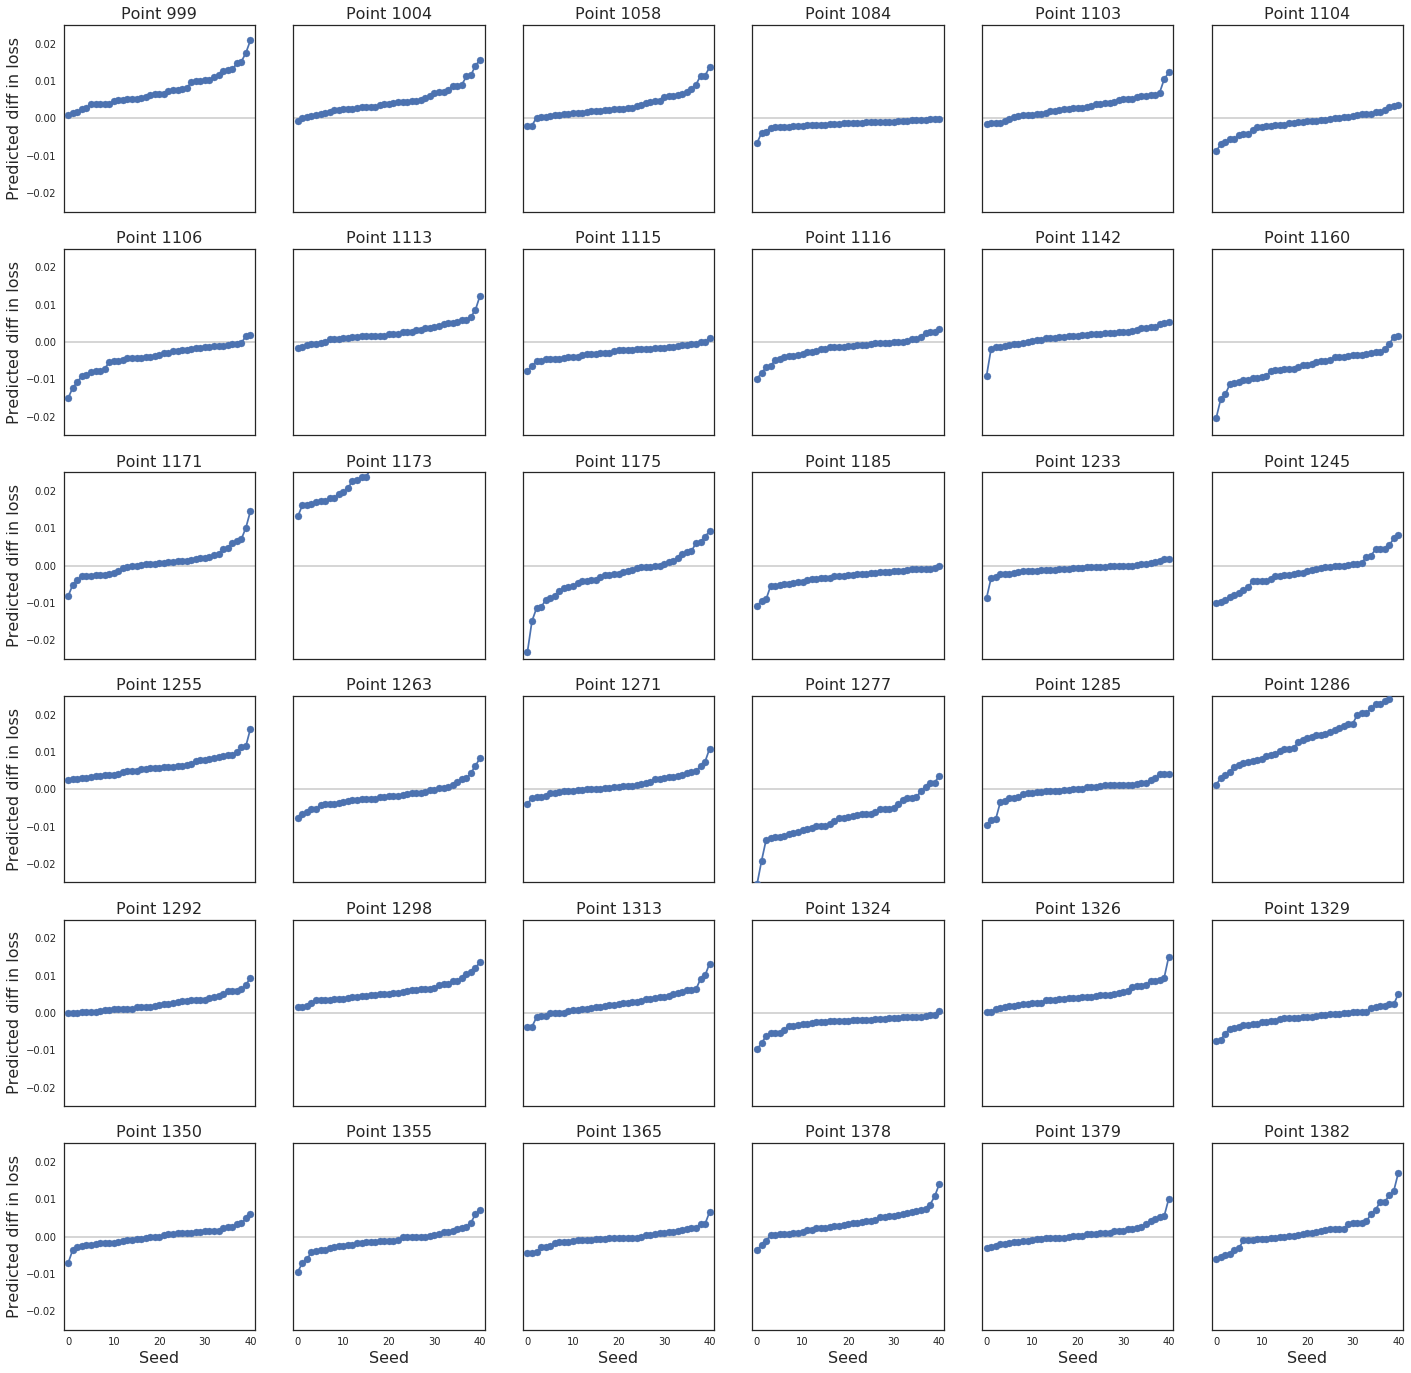

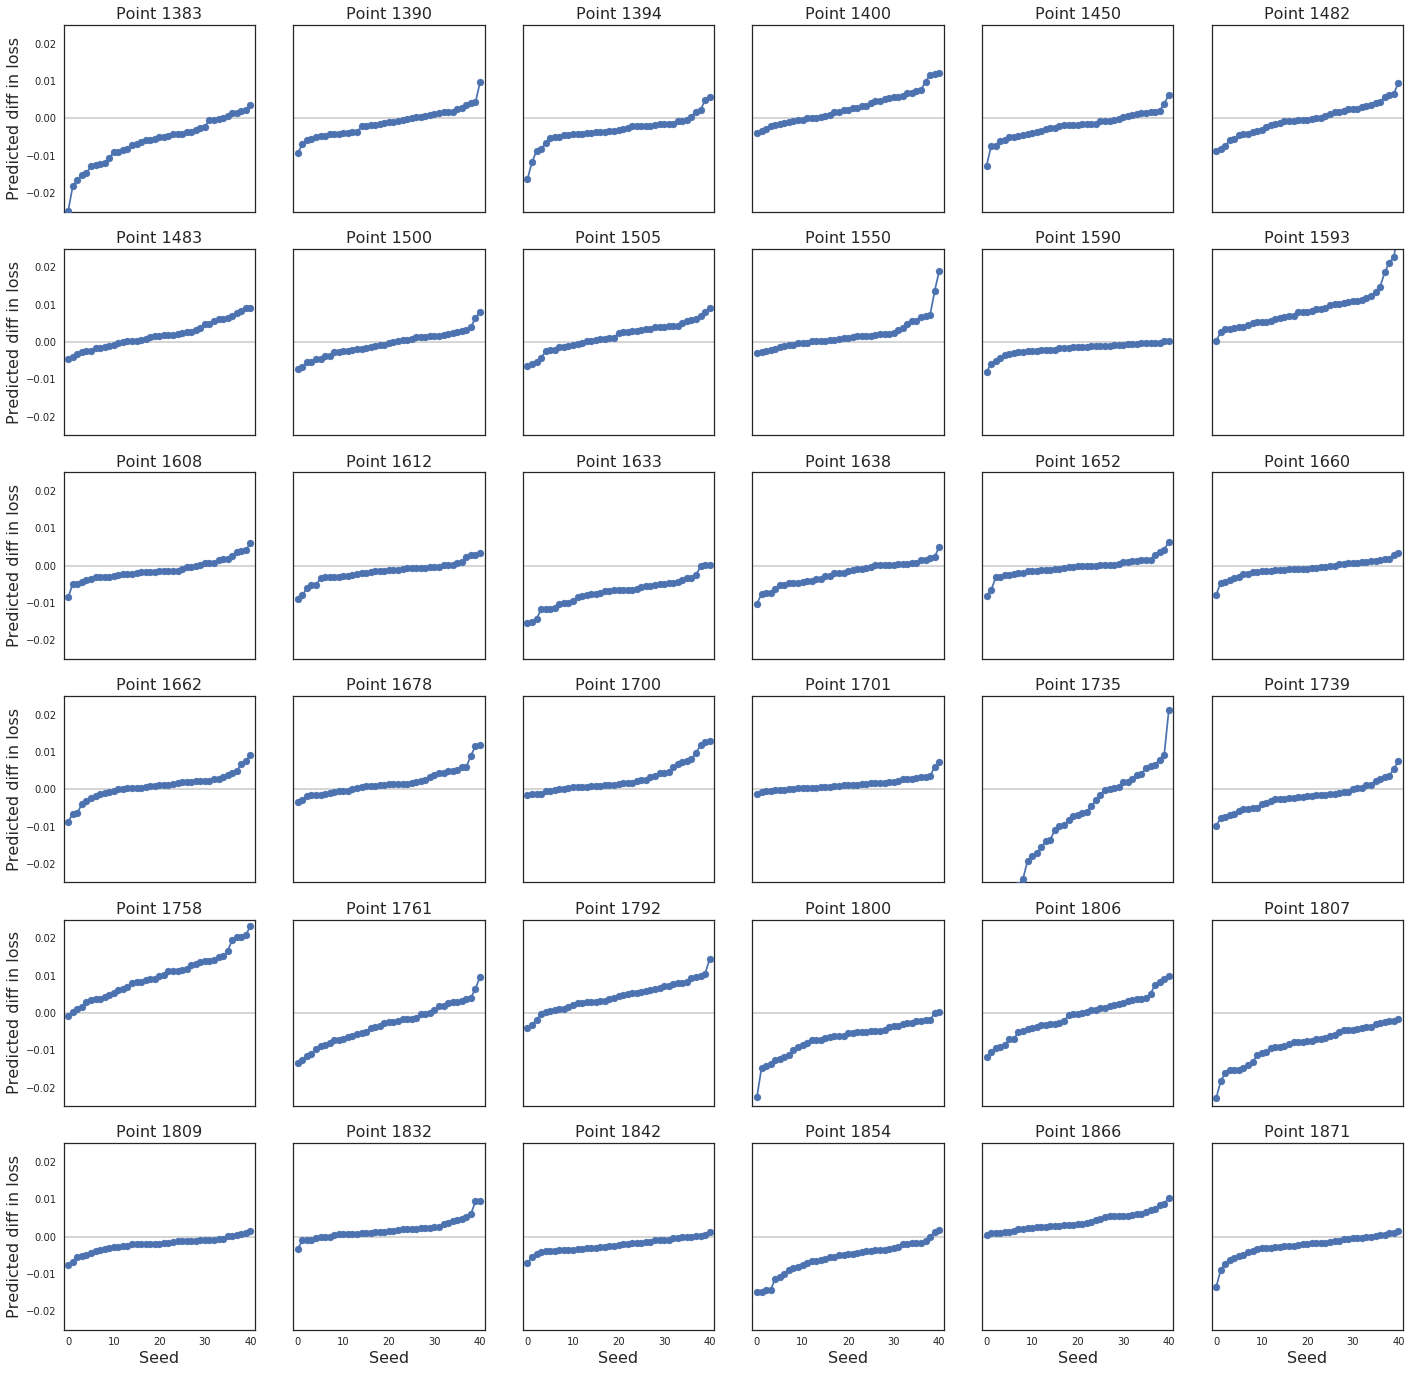

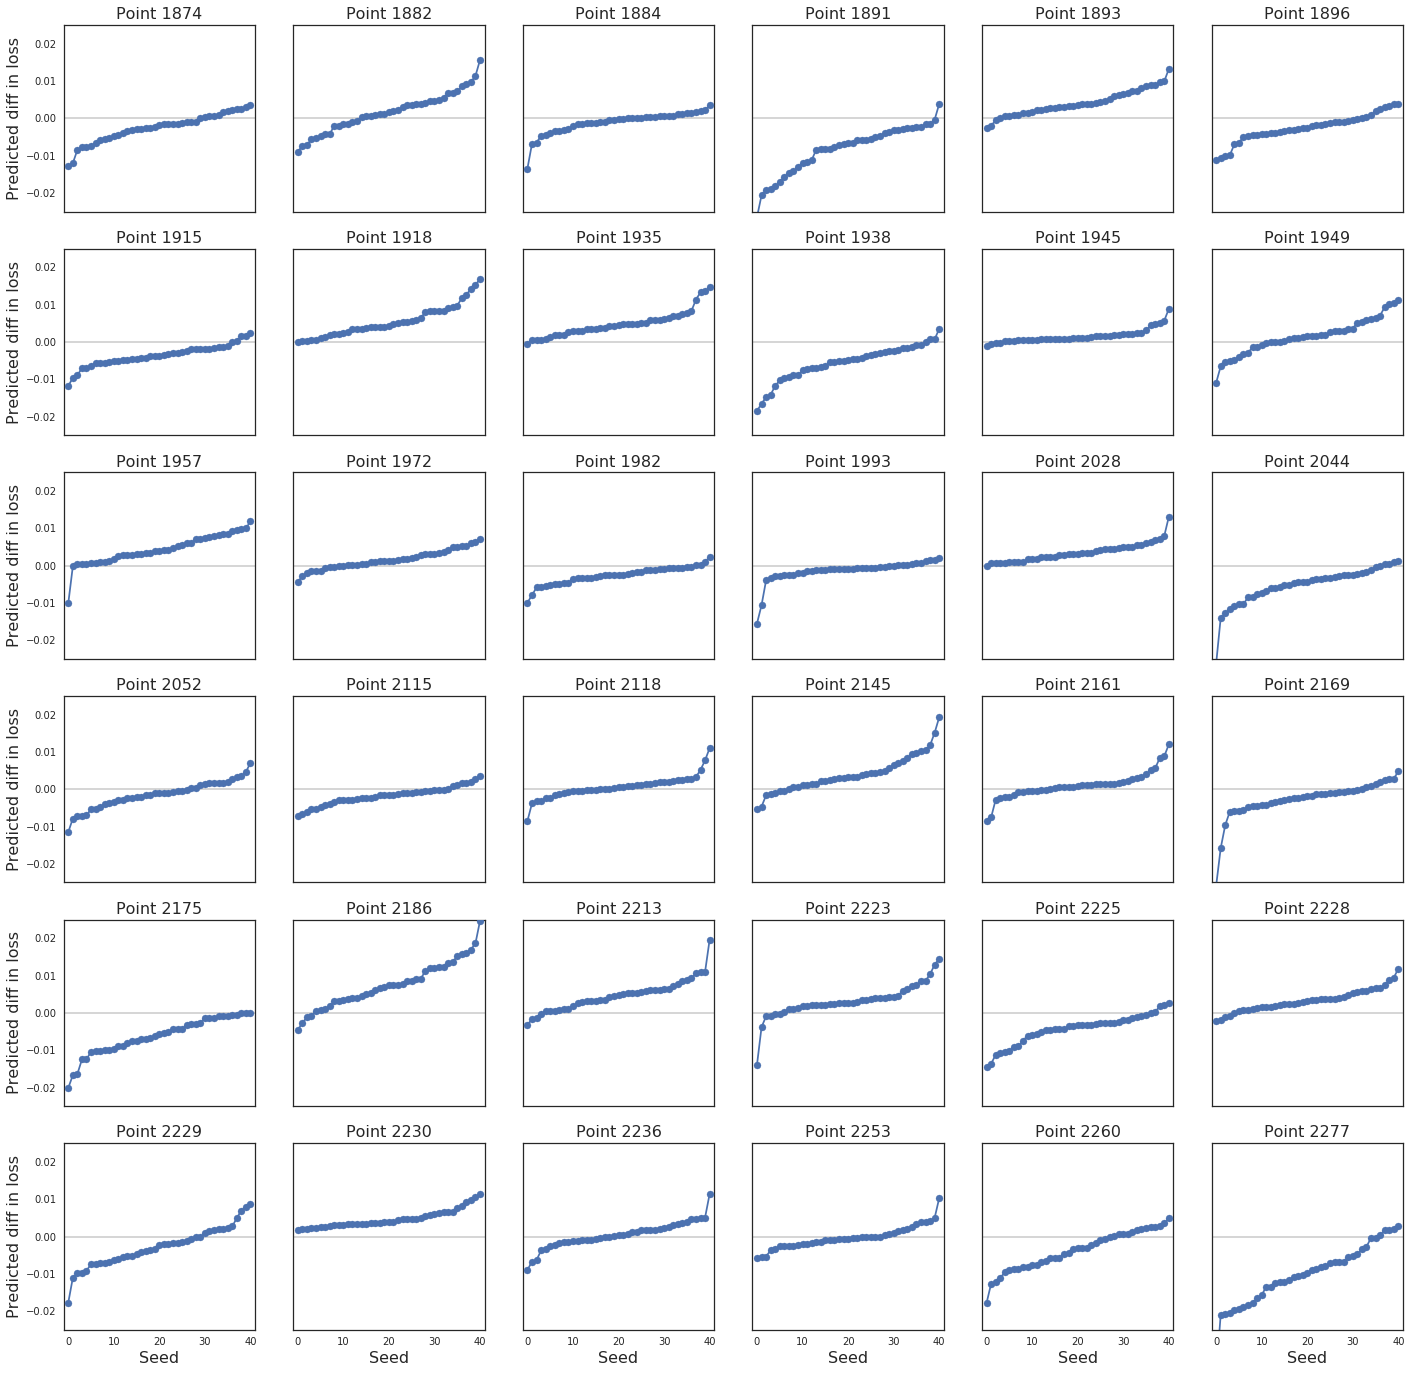

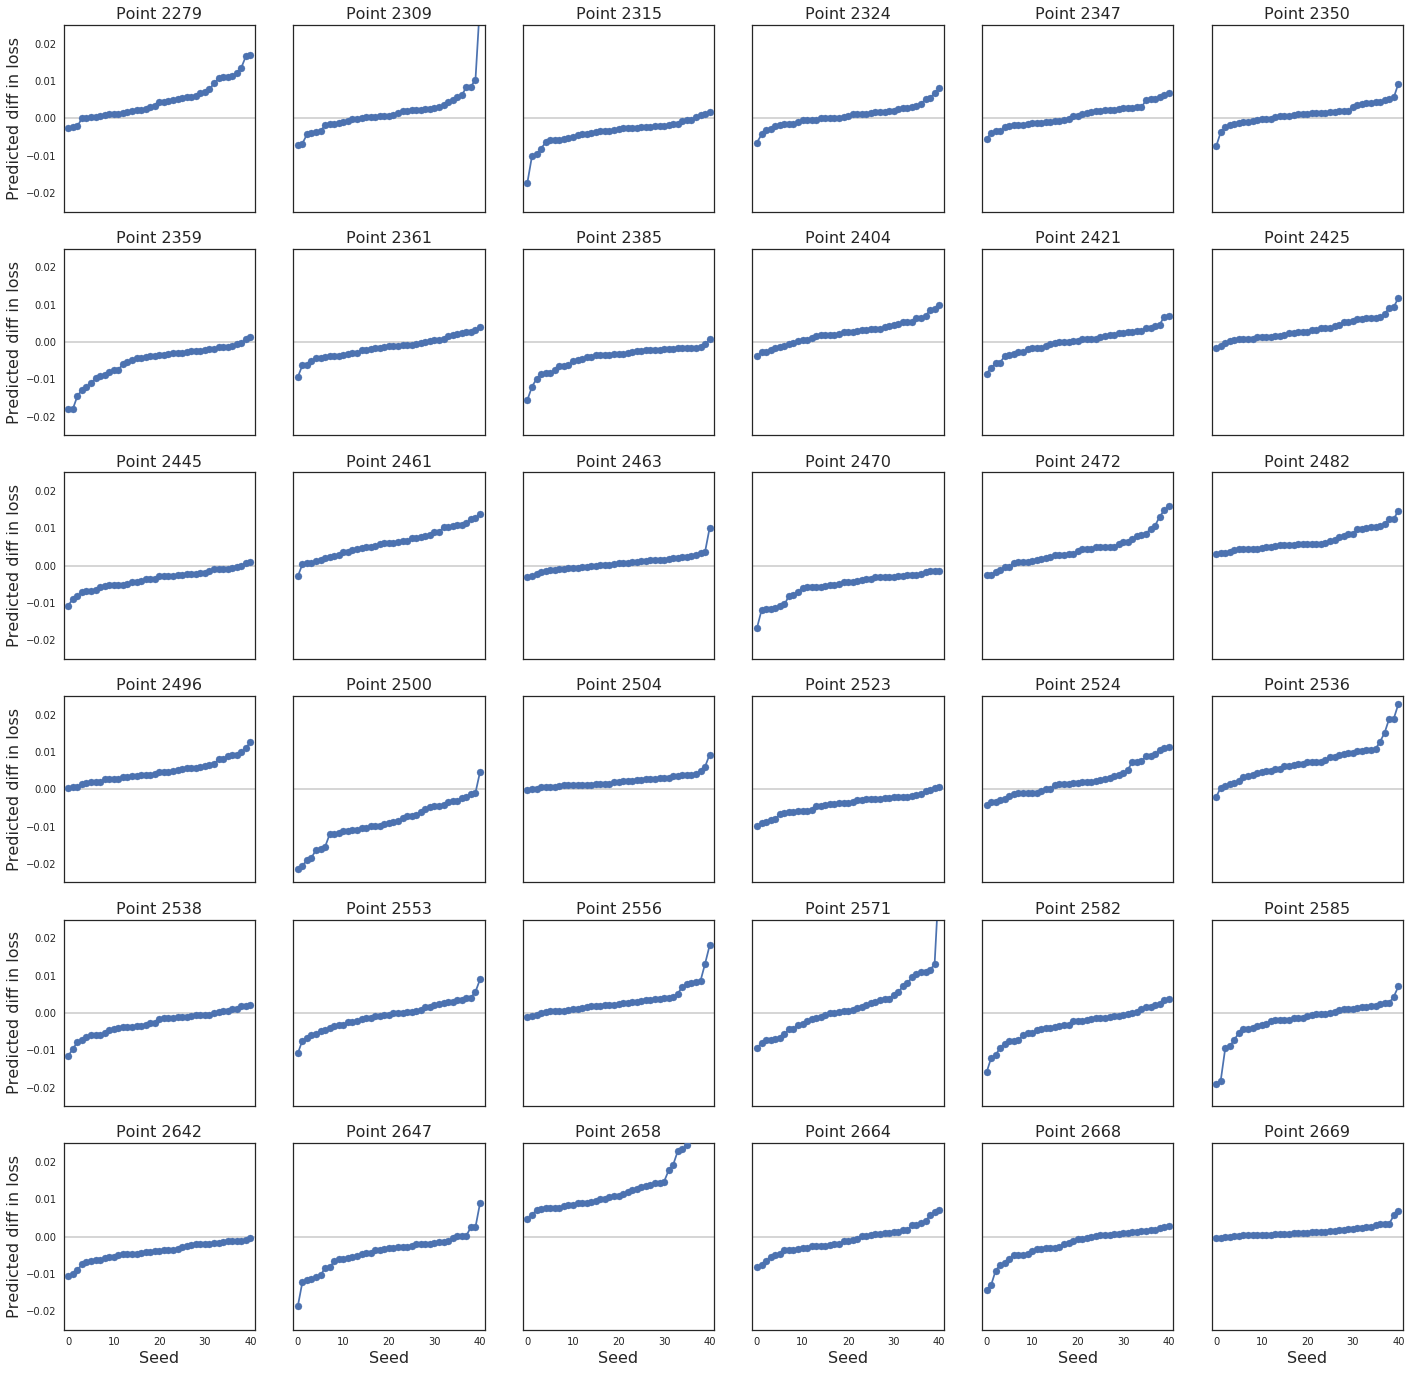

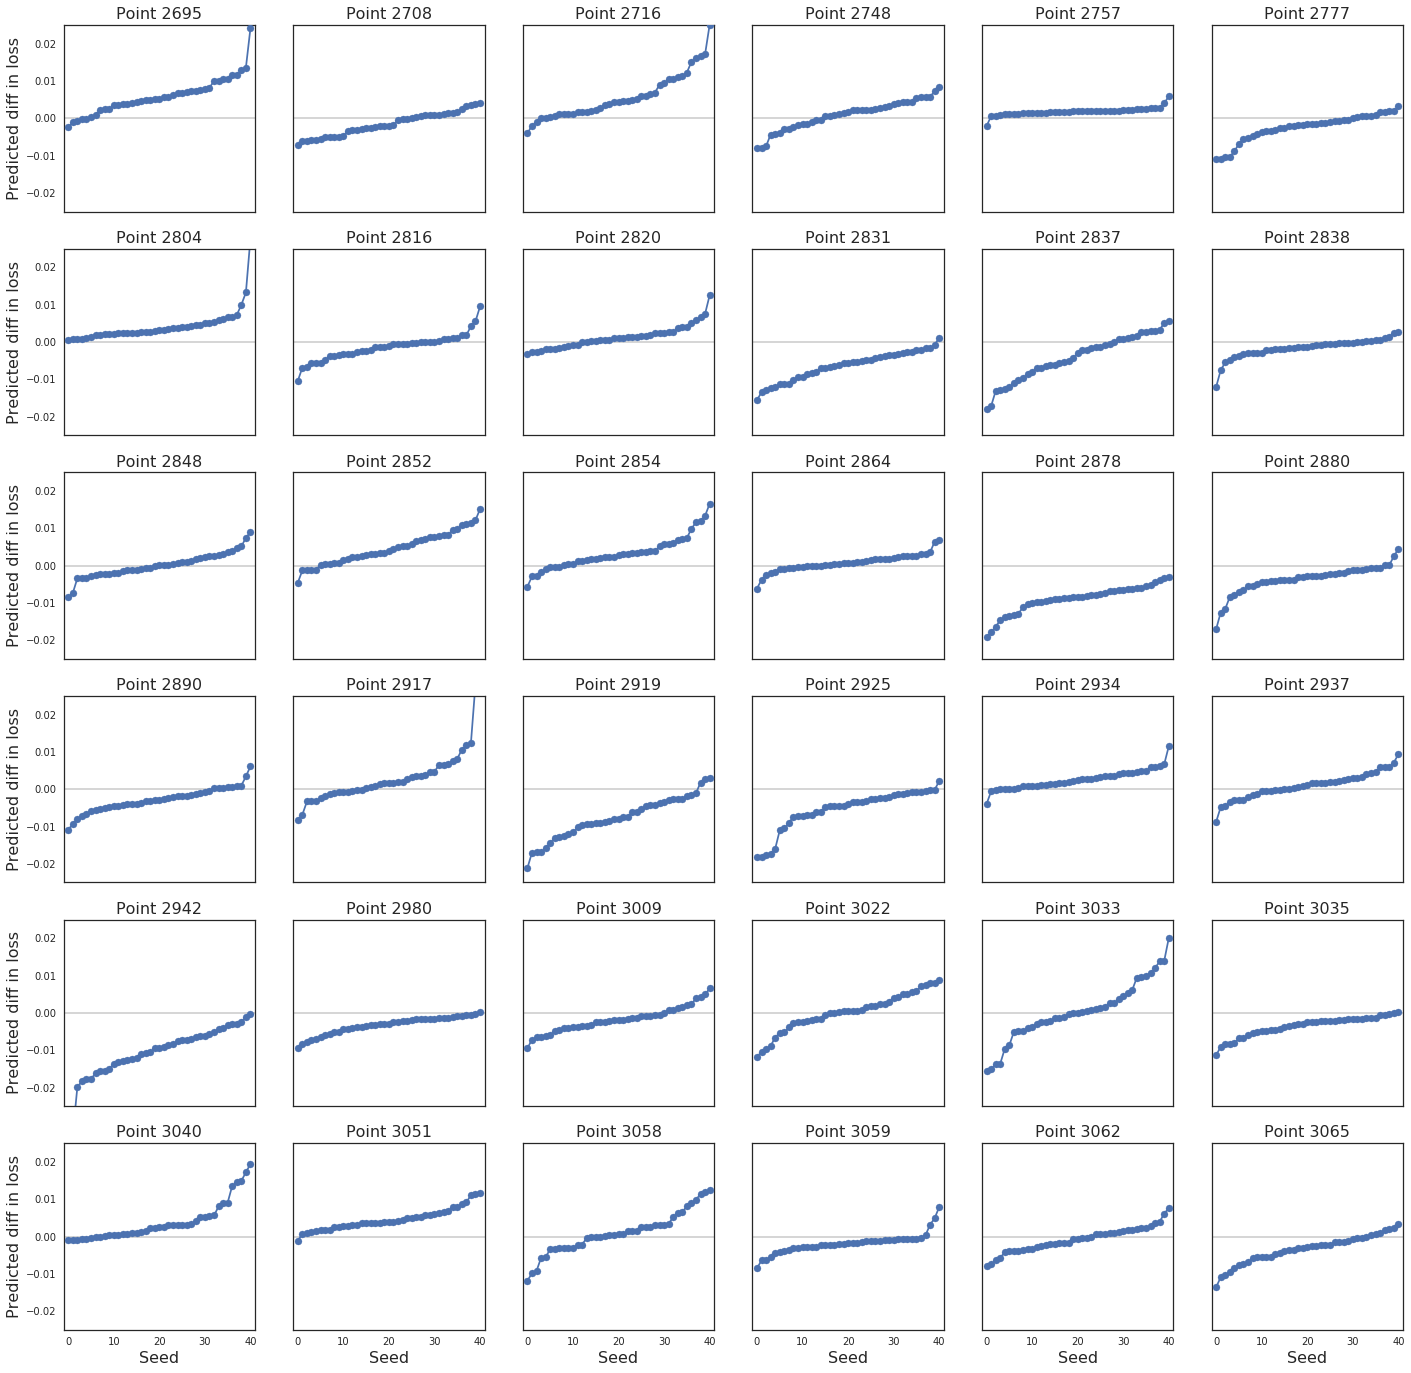

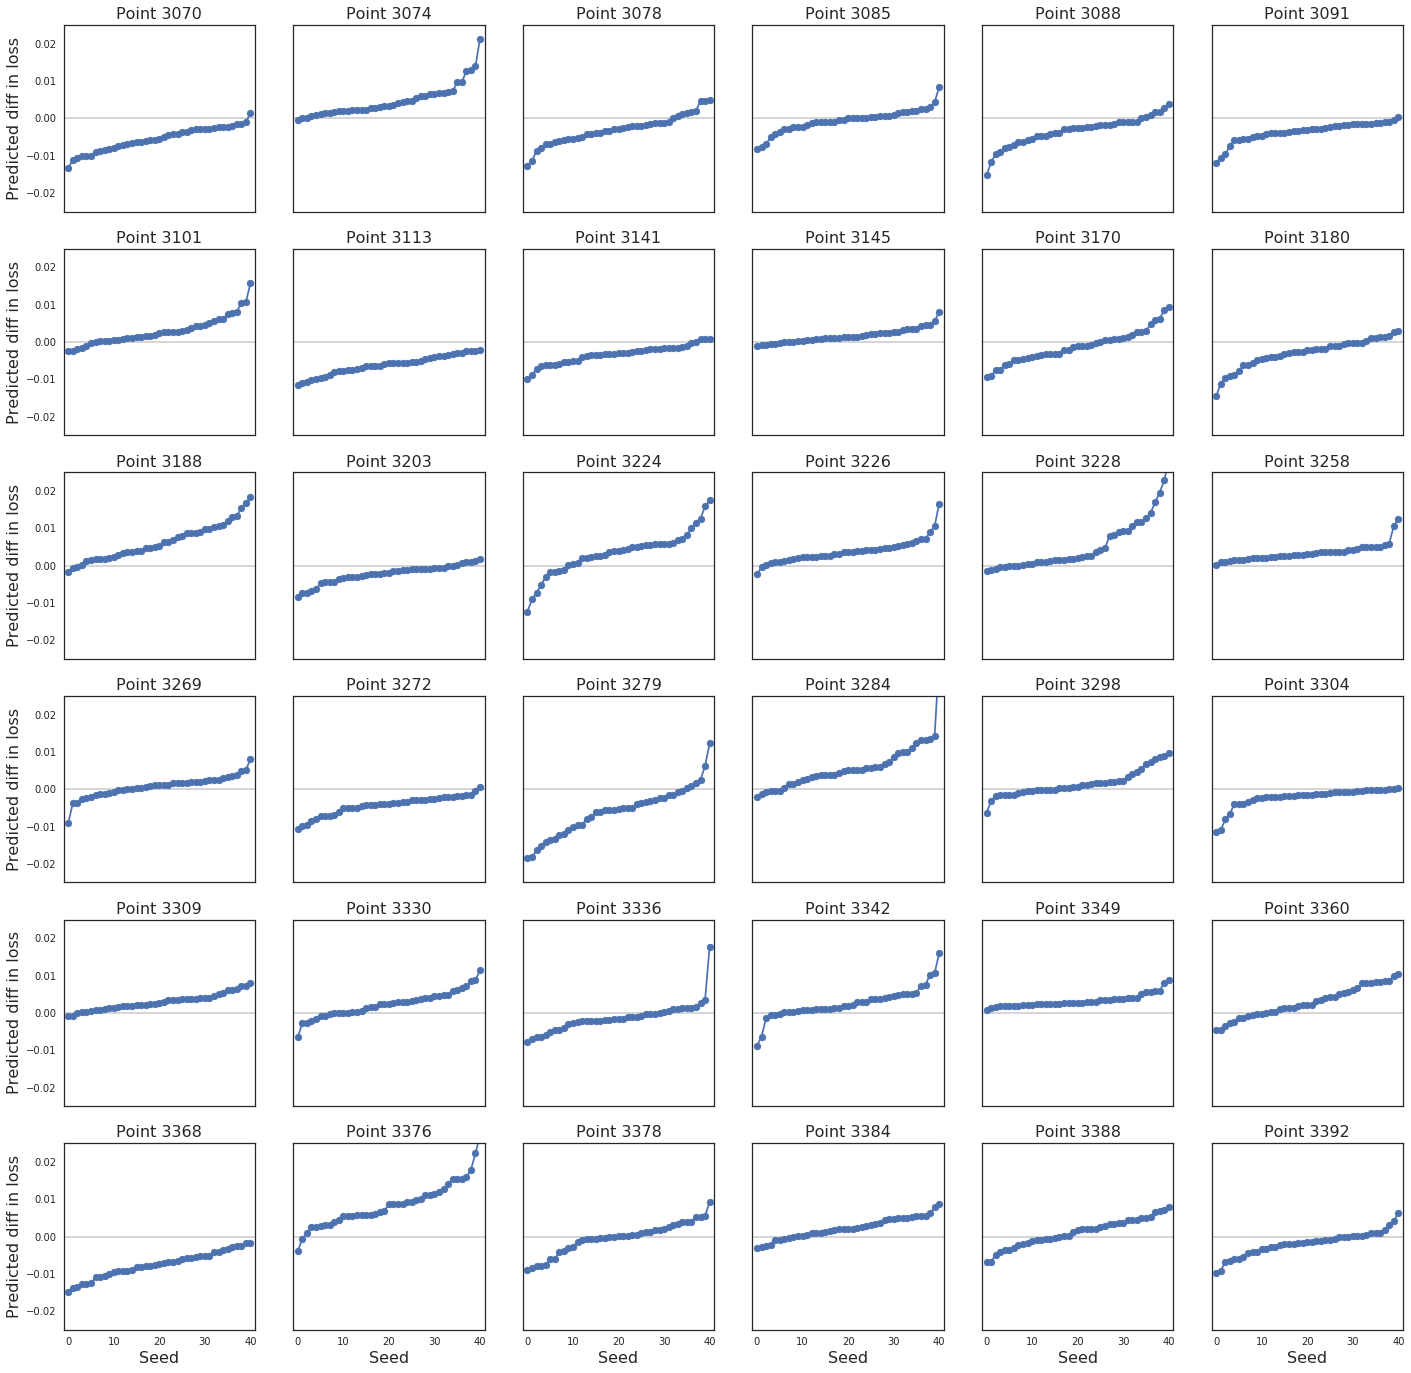

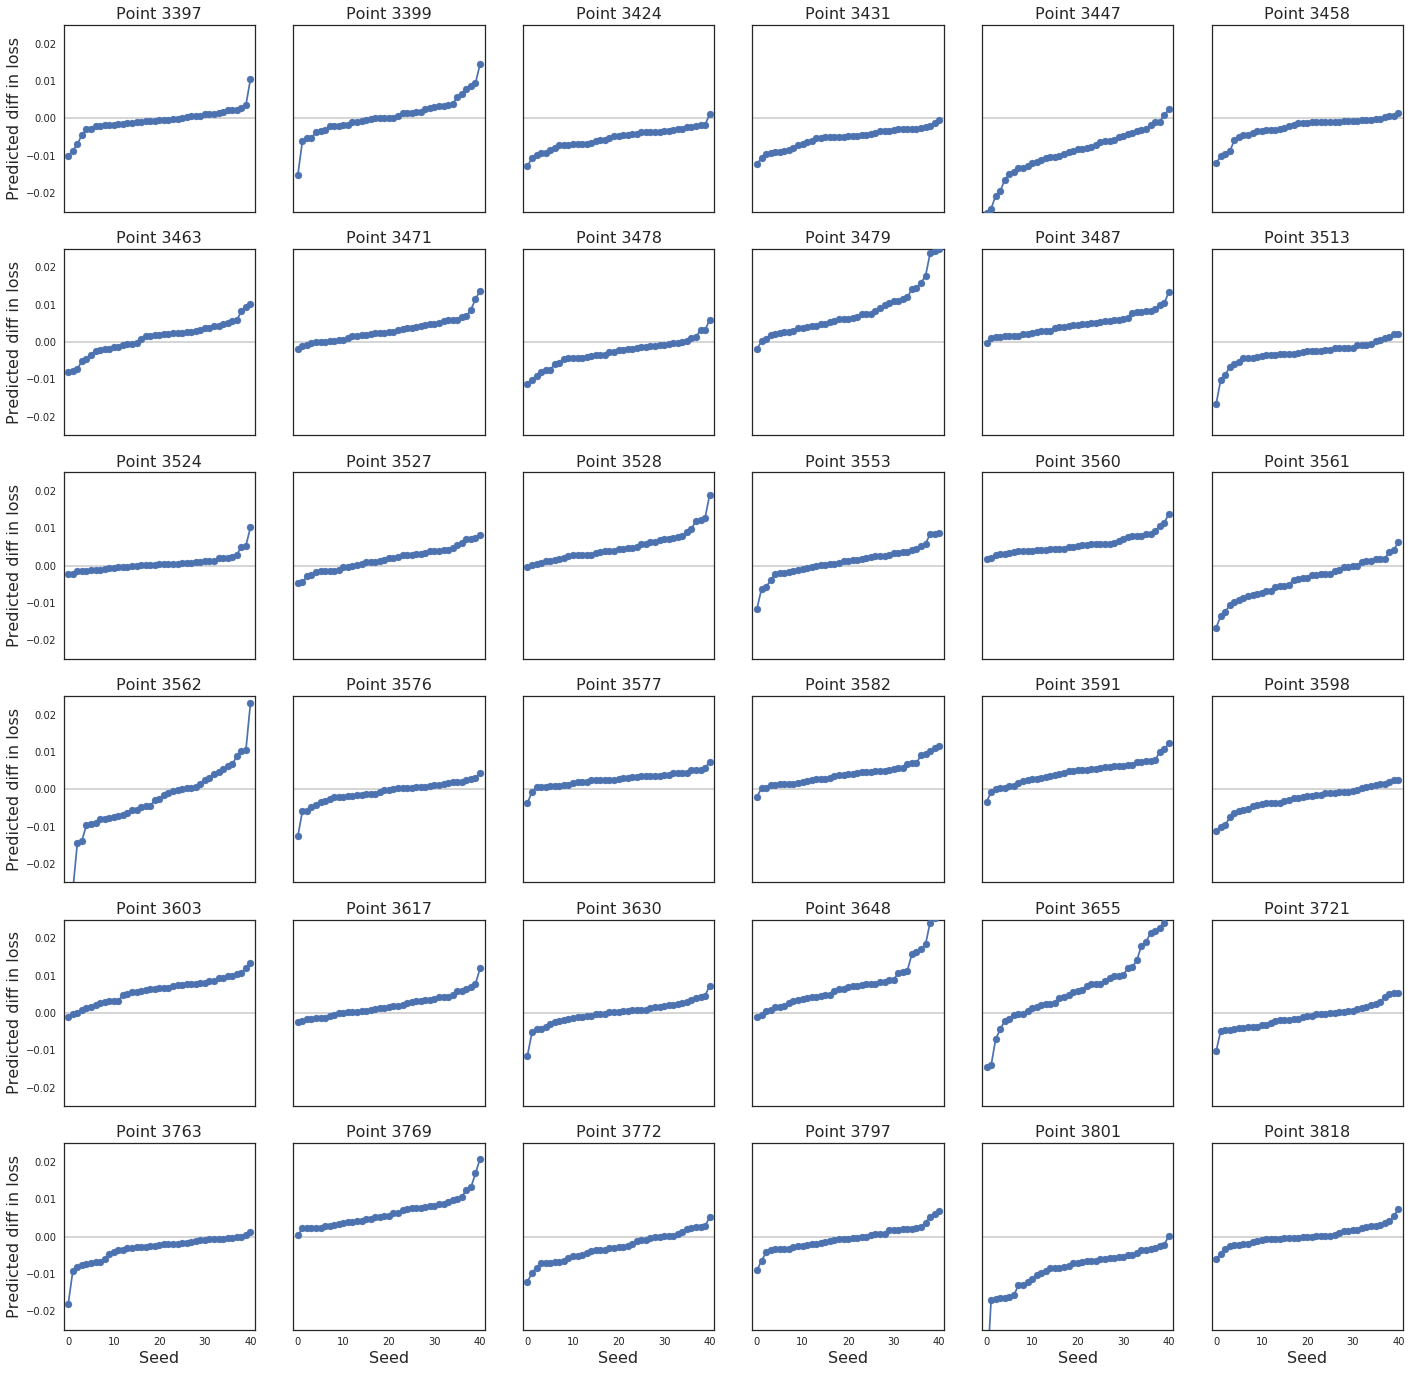

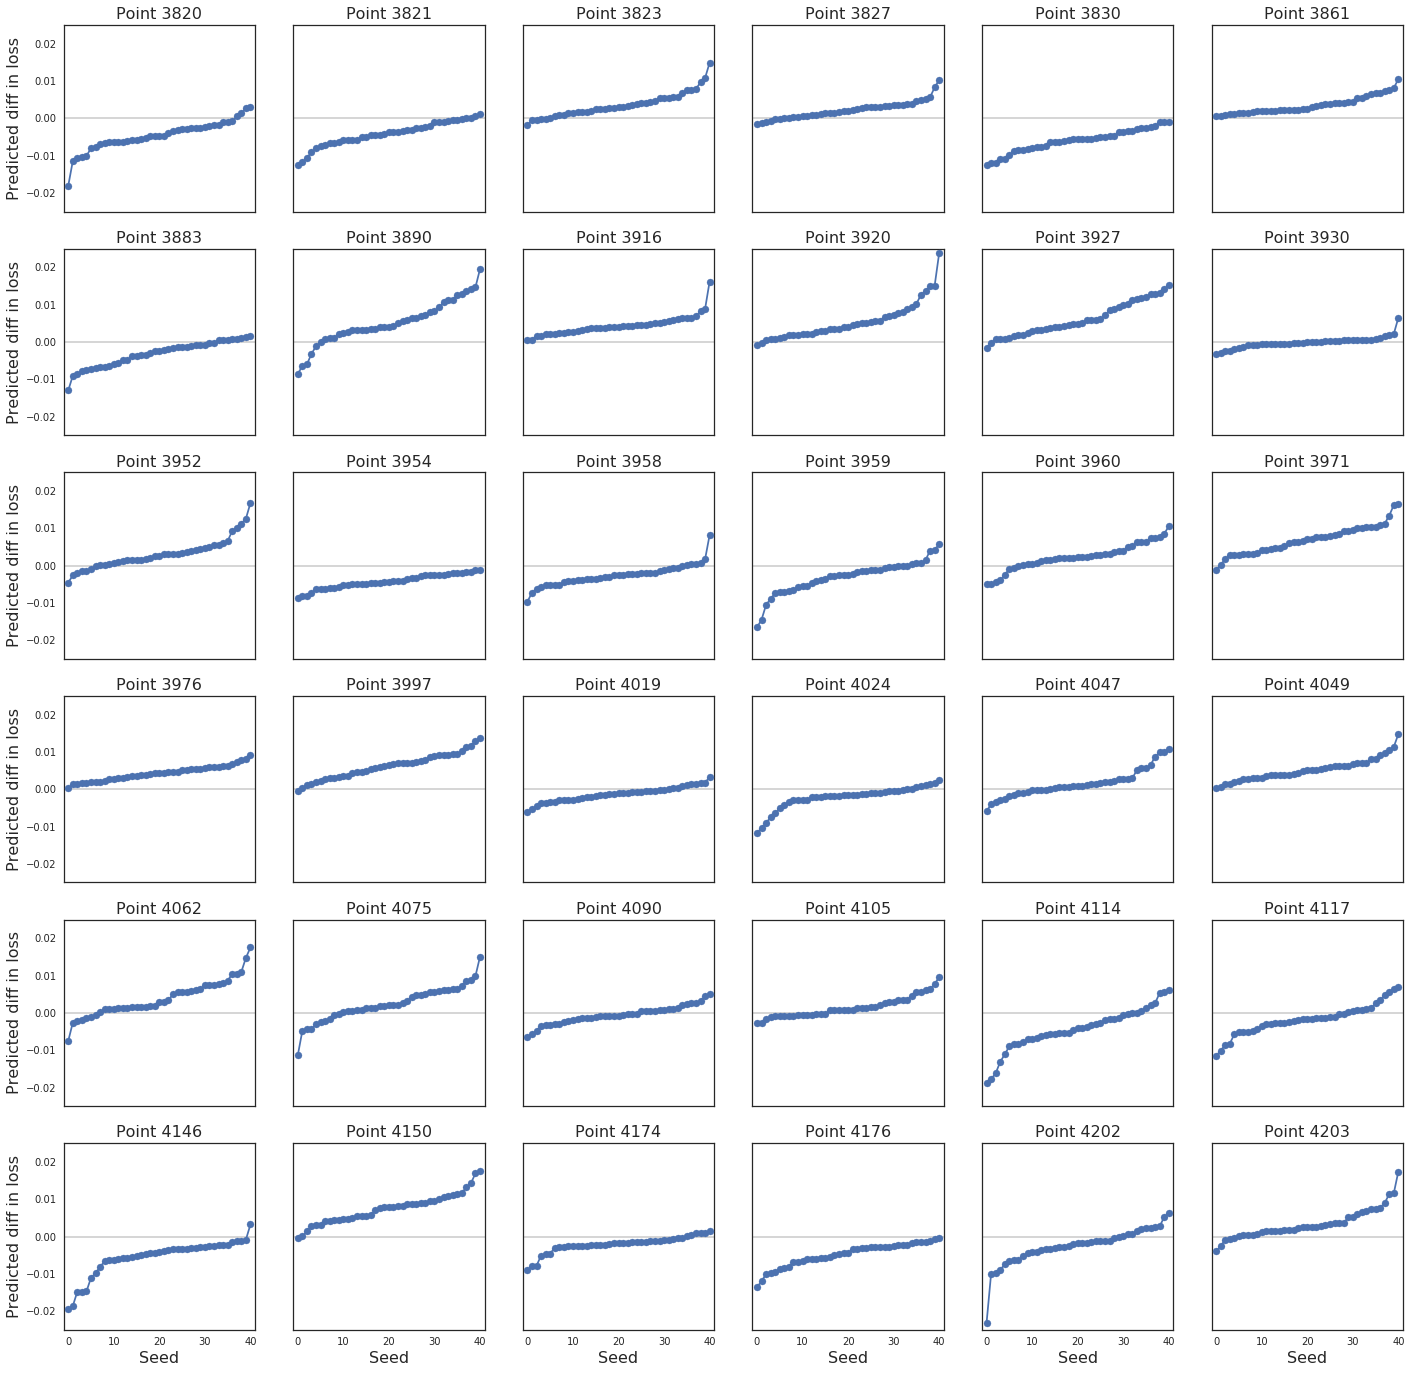

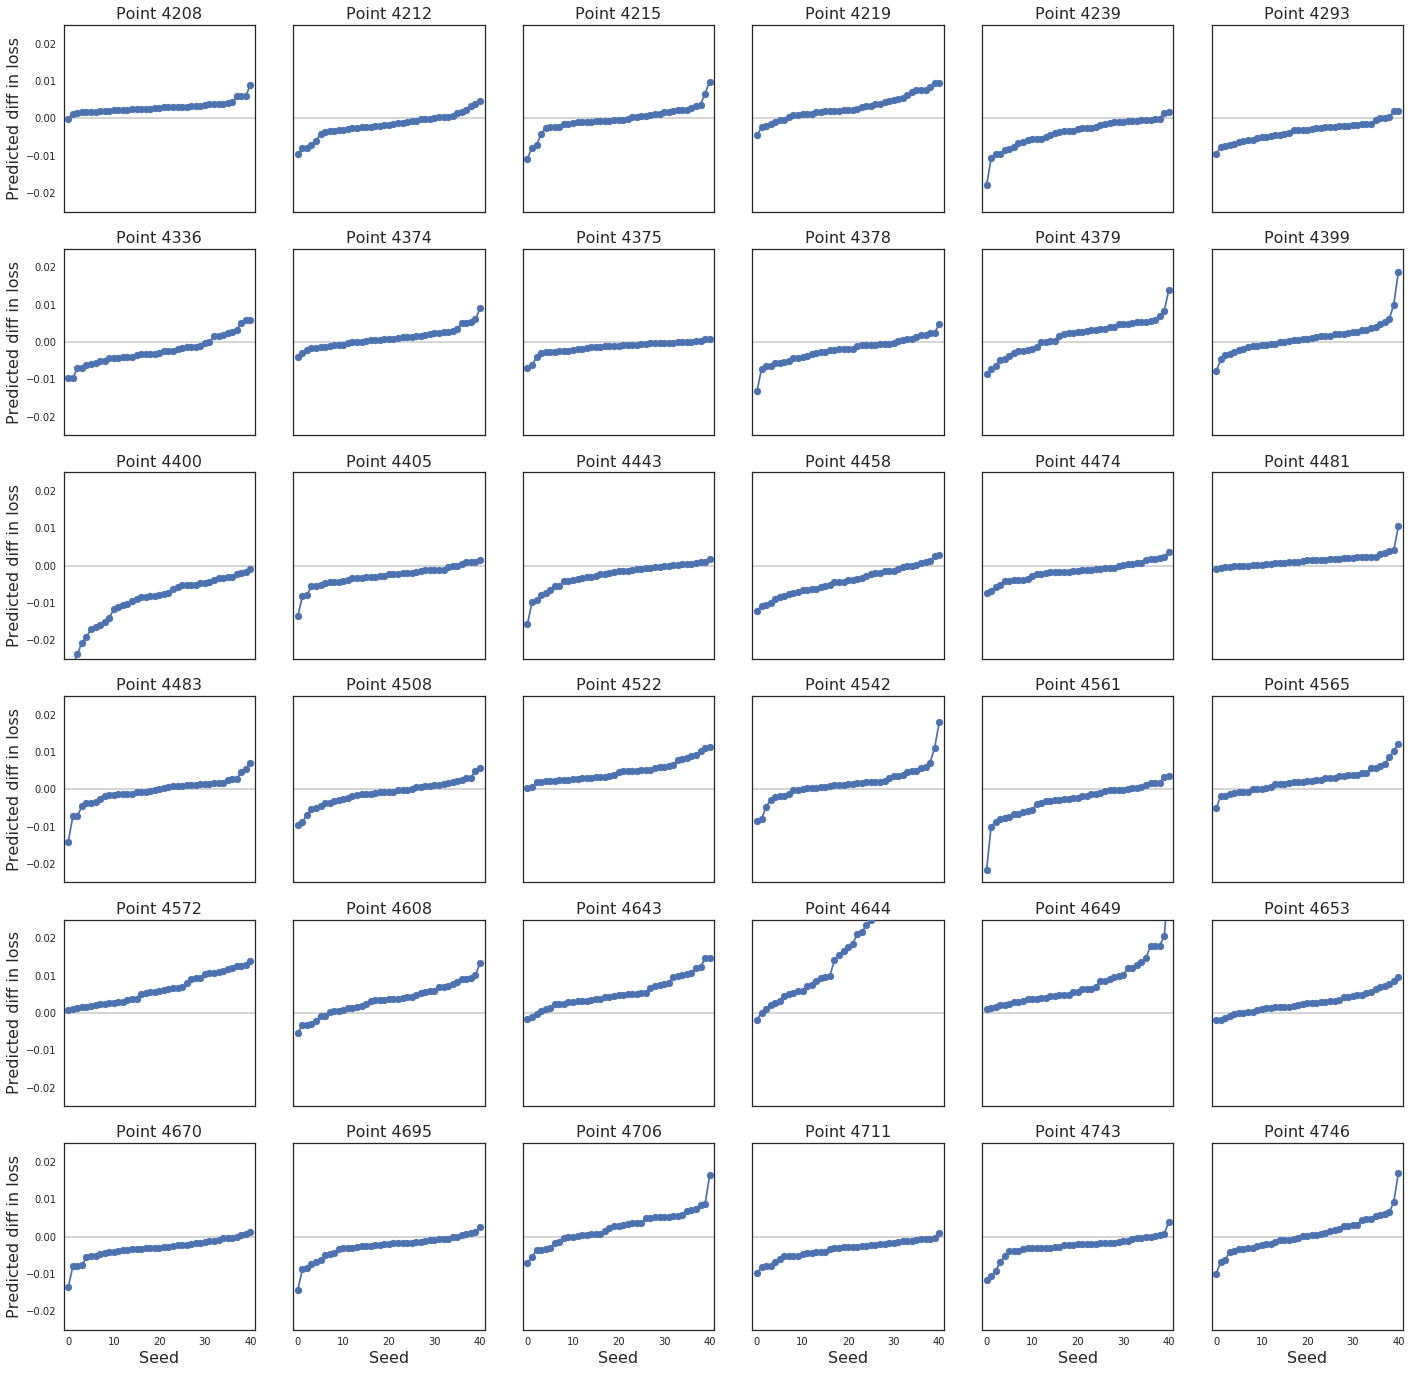

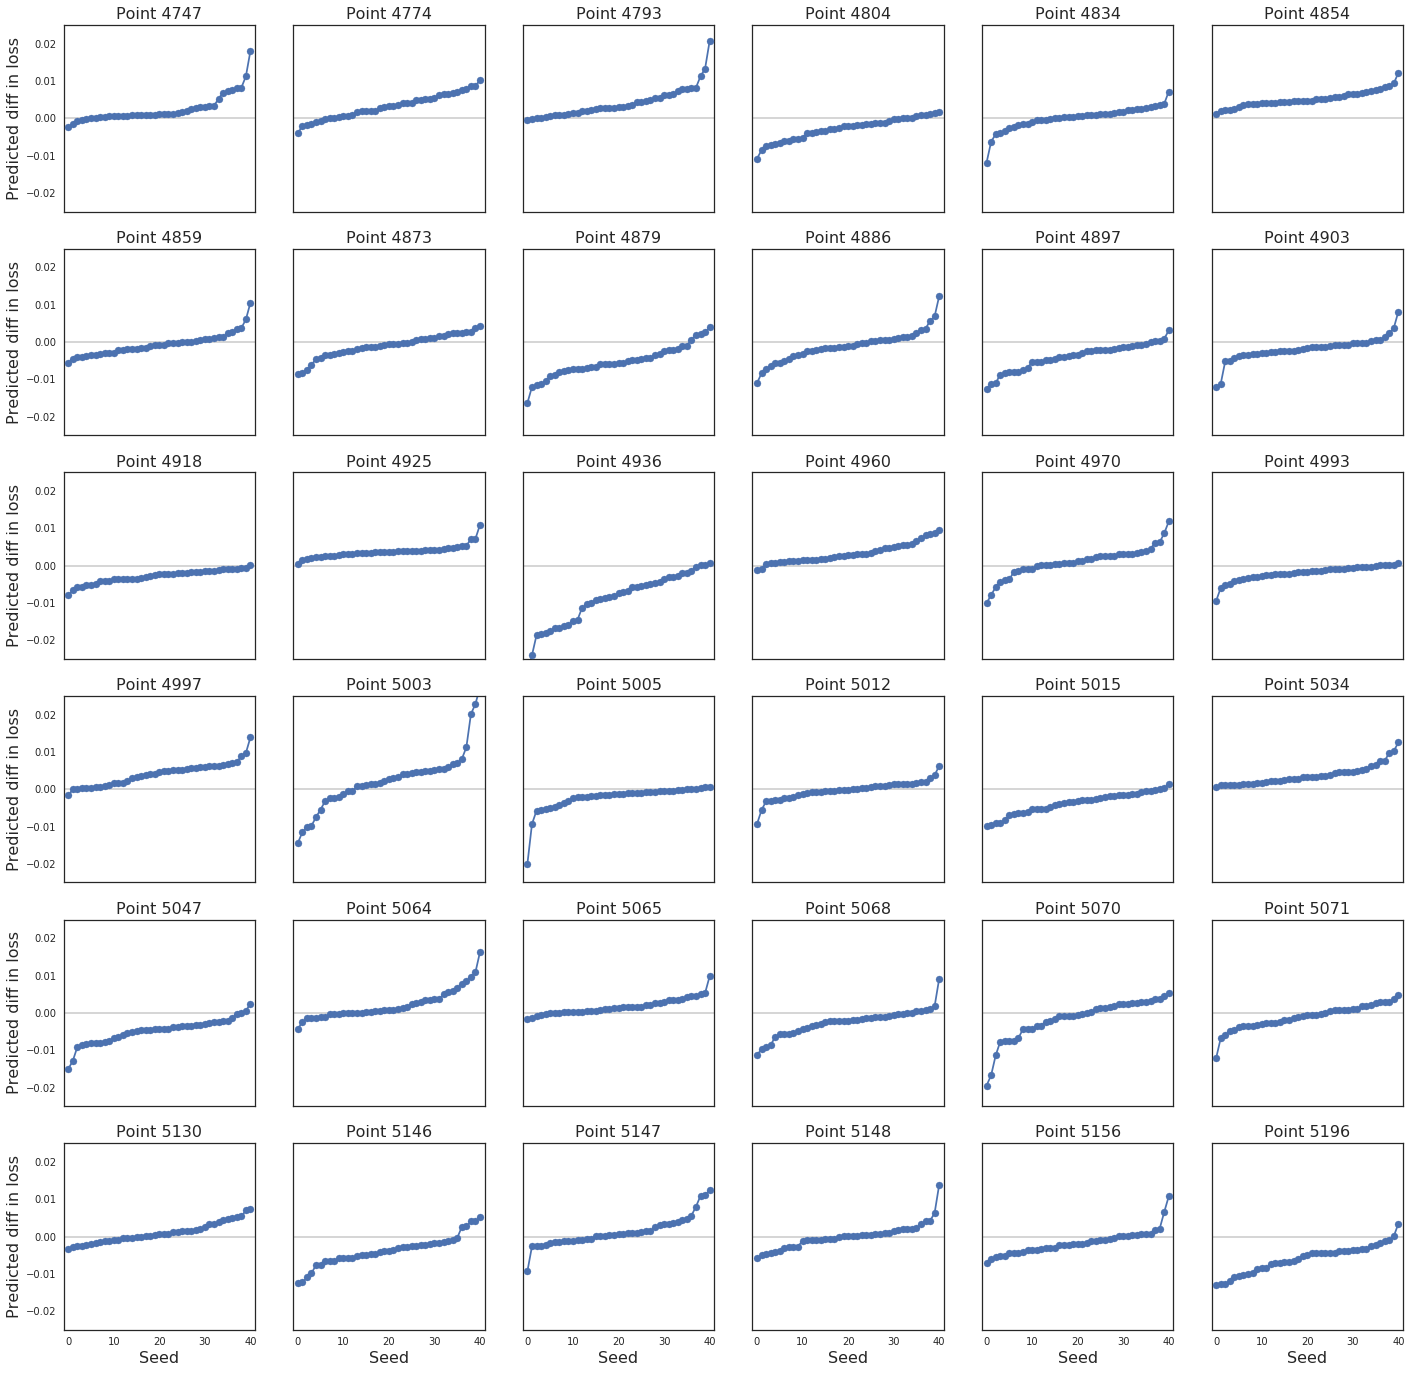

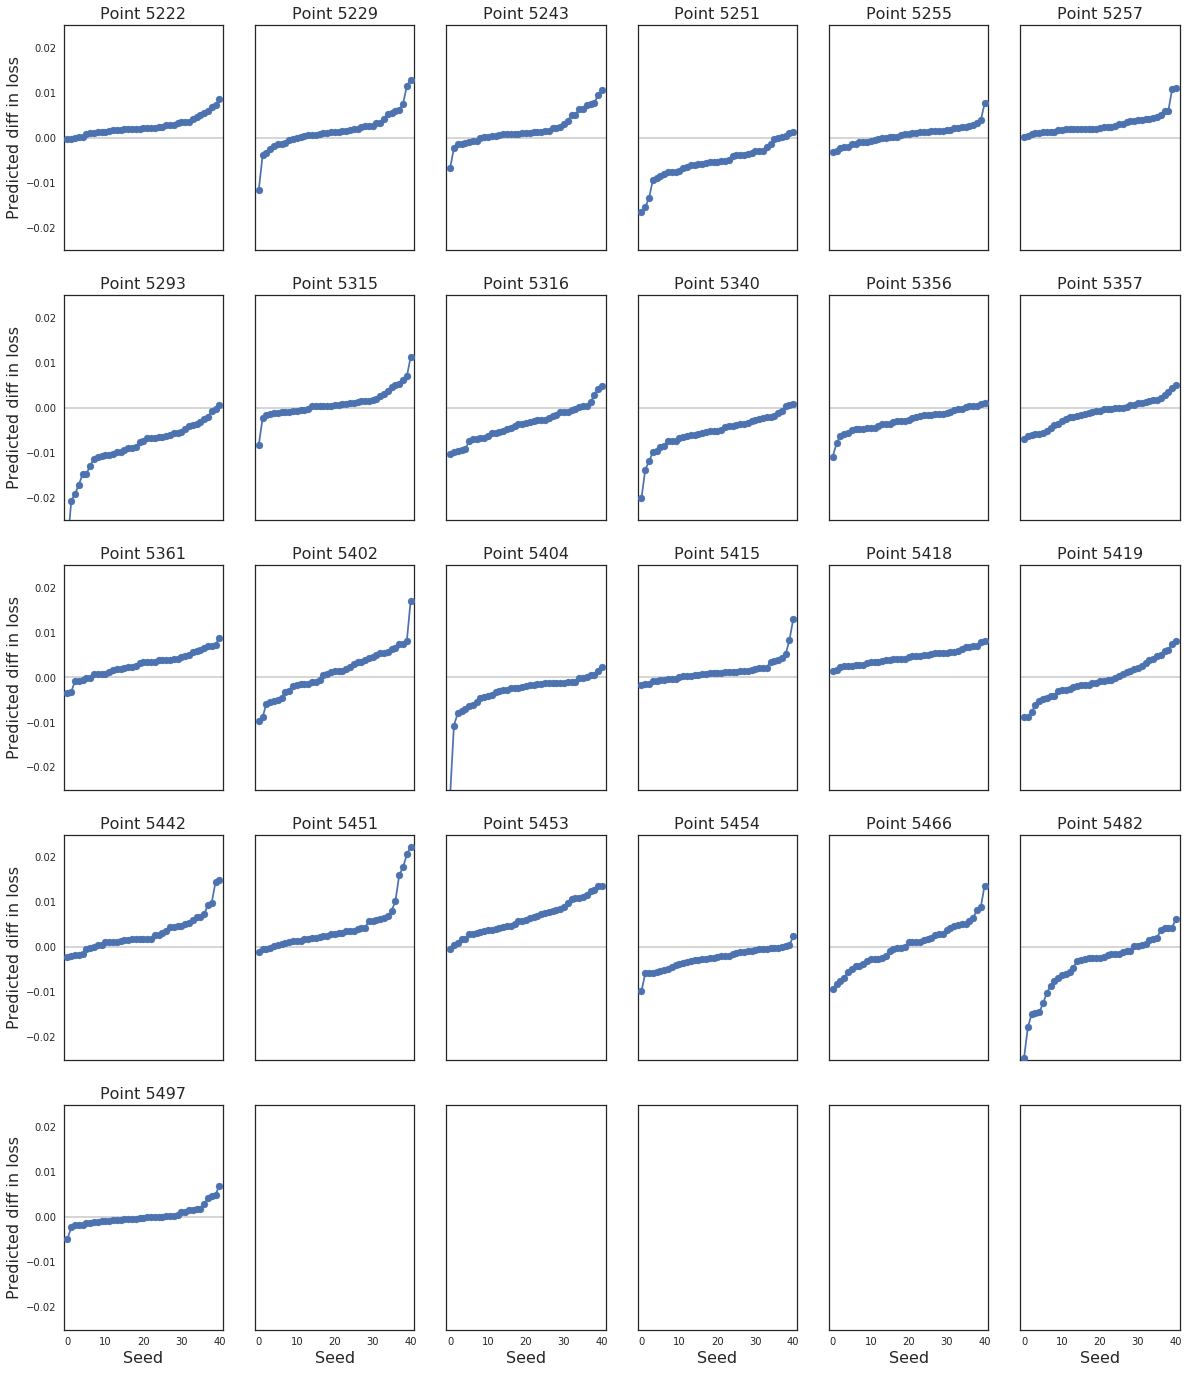

In [3]:
num_groups = ceil_divide(len(influential_indices),group_sz)
for group in range(num_groups):
    sns.set_style('white')
    fontsize=16
    width = 6

    if style == "top_infl":
        num_points = group_sz if group != num_groups - 1 else len(influential_indices) % group_sz
        height = ceil_divide(num_points,width)
        point_ids = influential_indices[group * group_sz : group * group_sz + num_points]
    if style == "random":
        height = 6
        num_points = height * width
        point_ids = np.random.choice(len(predicted_loss_diffs[0]),num_points)

    fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(4*height, 4*width))

    for row in axs: 
        row[0].set_ylabel('Predicted diff in loss', fontsize=fontsize)
        for ax in row:
            ax.set_aspect('auto')
            ax.set_xticks(np.arange(0, num_seeds, max(int(num_seeds/4),1)))
            ax.set_yticks(np.arange(-0.03, 0.04, 0.01))
            ax.set_xlim([-1,num_seeds])
            ax.set_ylim([-0.025, 0.025])
    for col in axs[-1]:
        col.set_xlabel('Seed', fontsize=fontsize)

    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            ind = len(row)*i+j
            if ind < num_points:
                point = point_ids[ind]
                ax.axhline(color='k',alpha=0.2,zorder=1)
                data = np.sort(predicted_loss_diffs[:,point])
                ax.plot(range(num_seeds), data, zorder=2)
                ax.scatter(range(num_seeds), data, zorder=3)
                ax.set_title('Point {}'.format(point), fontsize=fontsize)

    plt.savefig('../../scr/figs/hidden2_infl_per_point_{}_group{}.png'.format(style, group), dpi=600, bbox_inches='tight')